In [1]:
import csv
import pickle
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mouselab.mouselab import MouselabEnv
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import math
import sklearn.cluster
from math import floor, ceil

# Reading Data from Files

In [2]:
fileprefix = "final" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

# Creating Trial Dataframe

In [3]:
part_stats_dicts = []
scarcity_level = 0.25
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    expectedScores = []
    numClicks = []
    avgClickLevel = []
    rewardsWithheld = []
    demographicsAvailable = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
    except:
        print("No data")
        continue
    lastTrialStamp = participant['data'][-1]['dateTime']
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    stroop_timestamps = {
        "1" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        },
        "2" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        }
    }
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    stroop1Completed = 0
    stroop1Correct = 0
    stroop2Completed = 0
    stroop2Correct = 0
    last_trial = participant['data'][0]
    feedback = ""
    comments = ""
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
#         if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
#             print("{}\t{}\t{}".format(trial_type, trial_id, idx))
        if trial_id == "stroop_1_ready_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["start"] = trial['dateTime']
            
        if trial_id == "stroop_2_ready_1" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["start"] = trial['dateTime']
            
        if trial_id == "finish_distractor_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["end"] = trial['dateTime']
            stroop_timestamps["1"]["done"] = True
            
        if trial_id == "finish_distractor_2" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["end"] = trial['dateTime']
            stroop_timestamps["2"]["done"] = True
            
        if trial_id == "mouselab_instructions_1" and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            
        if "congruent" in trial_id or "incongruent" in trial_id or "unrelated" in trial_id:
            if not stroop_timestamps["1"]["done"]:
                stroop1Completed += 1
                
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop1Correct += 1
                
            else:
                stroop2Completed += 1
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop2Correct += 1
                    
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                
                # Getting expected scores
                g_truth = [0.0] + trial['trialdata']['stateRewards'][1:]
                mEnv = MouselabEnv.new_symmetric_registered('high_increasing', ground_truth=g_truth)
                clicks = trial['trialdata']['queries']['click']['state']['target']
                for click in clicks:
                    mEnv.step(int(click))
                
                
                # Saving the number of clicks and the average distance of all clicks
                numClicks.append(len(clicks))
                clicksL1 = len([c for c in clicks if int(c) in [1,5,9]])
                clicksL2 = len([c for c in clicks if int(c) in [2,6,10]])
                clicksL3 = len([c for c in clicks if int(c) in [3,4,7,8,11,12]])
                try:
                    avgLevel = (clicksL1 + 2*clicksL2 + 3*clicksL3)/len(clicks)
                except:
                    avgLevel = 0
                    
                avgClickLevel.append(avgLevel)
                planQuality = mEnv._term_reward() 
                + trial['trialdata']['costs']/(1.0 if participant['condition'] == 0 else scarcity_level)
                expectedScores.append(planQuality)
                
        if trial_type == 'survey-html-form':
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
                demographicsAvailable = True
                
        if trial_id.startswith("finish_fail"):
            demographicsAvailable = True
        if trial_type == 'survey-text':
            feedback = trial['trialdata']['response']['Q0']
            comments = trial['trialdata']['response']['Q2']
        last_trial = trial

    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps, stroop_timestamps["1"], stroop_timestamps["2"]], ["mdp", "s1", "s2"]):
        if obj["start"] > 0 and obj["end"] == 0:
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
            
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "condition": participant['condition'],
        "stroop1Length" : (stroop_timestamps["1"]["end"] - stroop_timestamps["1"]["start"]) / 1000,
        "stroop2Length" : (stroop_timestamps["2"]["end"] - stroop_timestamps["2"]["start"]) / 1000,
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "stroop1Completed" : stroop1Completed,
        "stroop2Completed" : stroop2Completed,
        "stroop1Correct" : stroop1Correct,
        "stroop2Correct" : stroop2Correct,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "comments": comments,
        "expectedScores": expectedScores,
        "numClicks": numClicks,
        "avgClickLevel" : avgClickLevel,
        "demographicsAvailable": demographicsAvailable
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["stroop1Length"] + part_stats_dict["mouselabLength"] + part_stats_dict["stroop2Length"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

60fd5adad03767cff6dddda8
631a24dfca851aac1863e4a4
601903cdcd7cd6213bf60d64
5c629b836e03a00001d47bdd
615f4115250650ede6f83270
608c0288bce208aa19b5e302
60e43d16eb3536f1618652fb
6165d04961f94aba783d4529
611cccc7df12bfa05e6135e0
615aff05691d41b8ce734ca0
6115fcb4fcbab96f3ceb1734
5d7d00bb64f400001bd72301
60143a1a222eb43daf203877
5dafea4de40355001651fa2f
5ae7cdd9a0e4390001f08f12
5d21e78e5a2cea0016a843c4
6081e753b16df5194cf90f49
5e5012ec47808406305d6a0d
6155d029515651d612ad2141
5e89d0a17ec160000888ee98
5ebdb1414b3e5d0e1e46e76d
604b169fe4b7991ec08da3a6
60217ceca41dfb1639d152a7
5efd2964d36f63162f263795
5f16ccc87d339d0008e08016
60fe8586944a3f20fd5e8db2
5ec51242bc5aac433c0450ec
60a2d0f8a996c447692d4b73
5ec79cbd44972a1fceed2719
5f388a9c9604723a294bc377
5f69e356d68b93020e622bf2
60f88d7fef1959734061e5a7
5974ce5364b35a00019dd811
6088a7e22d5b98ef3f813a22
610ce0a48fc7e68abc4070c1
5aa54dca873cda00012cfaf8
No data
5f2664edcb7a443902254785
5eb2e299831ce0092dd2b965
6163d356472f53c054893857
5f4f9d1609e969066

In [4]:
# Compiling all data into trial data

all_trial_data = {
    "trialScores": [],
    "expectedScores": [],
    "numClicks" : [],
    "avgClickLevel" : [],
    "trialNumbers": [],
    "scarce": [],
    "numRewardedTrials": [],
    "numUnrewardedTrials": [],
    "workerId": [],
    "rewardsWithheld" : [],
}

count = 0;

for part in part_stats_dicts:
    if len(part['trialScores']) not in [30, 120]:
        print(part['condition'], part['workerId'], "MDP Data Incomplete")
        continue
        
    # Include in analysis only those participants whose data is complete
    if not part['demographicsAvailable']:
        print(part['condition'], part['workerId'], "Demographics missing")
        continue
    count += 1
    all_trial_data['trialScores'] += part['trialScores']
    all_trial_data['rewardsWithheld'] += part['rewardsWithheld']
    all_trial_data['workerId'] += [part['workerId']] * len(part['trialScores'])
    all_trial_data['expectedScores'] += part['expectedScores']
    all_trial_data['numClicks'] += part['numClicks']
    all_trial_data['avgClickLevel'] += part['avgClickLevel']
    all_trial_data['trialNumbers'] += list(range(1,len(part['trialScores'])+1))
    all_trial_data['scarce'] += [int(len(part['trialScores']) == 120)] * len(part['trialScores'])
    all_trial_data['numRewardedTrials'] += [i - sum(part['rewardsWithheld'][0:i]) for i in range(len(part['trialScores']))]
    all_trial_data['numUnrewardedTrials'] += [sum(part['rewardsWithheld'][0:i]) for i in range(len(part['trialScores']))]

all_trials_df = pd.DataFrame(all_trial_data)


1 601903cdcd7cd6213bf60d64 MDP Data Incomplete
0 5f16ccc87d339d0008e08016 MDP Data Incomplete
0 60a2d0f8a996c447692d4b73 Demographics missing
0 5974ce5364b35a00019dd811 MDP Data Incomplete
0 610ce0a48fc7e68abc4070c1 MDP Data Incomplete
1 6131460946d0022f68082db6 MDP Data Incomplete
0 5d8aa1e3eab19600163d9ab7 Demographics missing
0 5db9e0044a8eb40431d5e782 Demographics missing
0 60ceaf82080f57fb967341d2 MDP Data Incomplete
0 6103872a37b1dd5b8f350237 MDP Data Incomplete
0 6155a6764b2556042551a827 MDP Data Incomplete
0 5f2dc74f1f22490fbef32149 MDP Data Incomplete
0 60e122a66ca94d24c01664fa MDP Data Incomplete
1 614c58edcb19b4cb3a486666 MDP Data Incomplete
0 5df97fcd11d8796fd29e85e3 MDP Data Incomplete
1 6064b073d8b83b30f7975c8d MDP Data Incomplete
0 5b9207898a79b000013f9efe Demographics missing
1 60df3a39f23b7c55e0669e7b MDP Data Incomplete
0 60fef59b4d85390bc0357a7d MDP Data Incomplete
0 5f3a76043bb11c6786e731bf MDP Data Incomplete
1 60e5d224c2070a7adc97befe MDP Data Incomplete
1 6148c15

In [5]:
all_trials_df

,trialScores,expectedScores,numClicks,avgClickLevel,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld
0,23.0,28.0,6,2.000000,1,0,0,0,60fd5adad03767cff6dddda8,False
1,39.0,44.0,6,2.000000,2,0,1,0,60fd5adad03767cff6dddda8,False
2,-30.0,4.0,7,2.142857,3,0,2,0,60fd5adad03767cff6dddda8,False
3,24.0,22.0,7,2.142857,4,0,3,0,60fd5adad03767cff6dddda8,False
4,52.0,50.0,7,2.142857,5,0,4,0,60fd5adad03767cff6dddda8,False
...,...,...,...,...,...,...,...,...,...,...
15685,51.0,48.0,2,3.000000,26,0,25,0,601912cd193759016f9ba75b,False
15686,42.0,48.0,5,3.000000,27,0,26,0,601912cd193759016f9ba75b,False
15687,60.0,48.0,1,3.000000,28,0,27,0,601912cd193759016f9ba75b,False
15688,43.0,48.0,4,3.000000,29,0,28,0,601912cd193759016f9ba75b,False


## Analyzing Inferred Strategies

In [6]:
# Defining paths

results_path = '../results'
inferred_path = results_path + "/cm/inferred_strategies"

scarce_file = results_path + "/mouselab-mdp-final-scarce.csv"
control_file = results_path + "/mouselab-mdp-final-control.csv"

scarce_inferred = inferred_path + "/scarcity_scarce/strategies.pkl"
control_inferred = inferred_path + "/scarcity_control/strategies.pkl"

strategy_scores_scarce_path = results_path + "/cm/strategy_scores/scarcity_scarce_clickcost_0.25_strategy_scores.pkl"
strategy_scores_control_path = results_path + "/cm/strategy_scores/scarcity_control_clickcost_1.0_strategy_scores.pkl"


scarce_df_rows = []
control_df_rows = []

In [7]:
# Reading csv files

with open(scarce_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        scarce_df_rows.append([row[0], int(row[1])])
        
with open(control_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        control_df_rows.append([row[0], int(row[1])])

In [8]:
# Reading inferred strategies

with open(scarce_inferred, 'rb') as f:
    scarce_strategies = pickle.load(f)
    
with open(control_inferred, 'rb') as f:
    control_strategies = pickle.load(f)

In [9]:
strategy_df = all_trials_df[['workerId', 'trialNumbers', 'scarce']].copy()
strategy_df['strategy'] = [None] * len(strategy_df) 

In [10]:
for workerId, stratList in scarce_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue
    
for workerId, stratList in control_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue

In [11]:
# Reading strategy scores

with open(strategy_scores_scarce_path, 'rb') as file:
    strategy_scores_scarce = pickle.load(file)
    
with open(strategy_scores_control_path, 'rb') as file:
    strategy_scores_control = pickle.load(file)


In [12]:
# Creating the strategy score dataframes

strategy_scores_scarce_list = [[k,v] for k,v in strategy_scores_scarce.items()]
strategy_scores_control_list = [[k,v] for k,v in strategy_scores_control.items()]

scarce_cluster_df = pd.DataFrame(strategy_scores_scarce_list, columns=["strategy", "score"])
control_cluster_df = pd.DataFrame(strategy_scores_control_list, columns=["strategy", "score"])

# Scale to 0-1:
scarce_cluster_df['scoreScaled'] = (scarce_cluster_df['score'] - scarce_cluster_df['score'].min()) / (scarce_cluster_df['score'].max() - scarce_cluster_df['score'].min())
control_cluster_df['scoreScaled'] = (control_cluster_df['score'] - control_cluster_df['score'].min()) / (control_cluster_df['score'].max() - control_cluster_df['score'].min())



In [13]:
# Cluster the strategy scores

scarce_clusters = scipy.cluster.vq.kmeans(scarce_cluster_df['scoreScaled'], k_or_guess=[0.6,0.5,0.4])
scarce_cluster_centers = scarce_clusters[0]

control_clusters = scipy.cluster.vq.kmeans(control_cluster_df['scoreScaled'], k_or_guess=[0.6,0.5,0.4])
control_cluster_centers = control_clusters[0]

In [14]:
# Compute the cluster labels: 0 - adaptive, 1 - moderately adaptive, 2 - maladaptive

scarce_clusters_repeated = np.repeat(np.expand_dims(scarce_cluster_centers, axis=0), len(scarce_cluster_df), axis=0)
scarce_cluster_distances = (scarce_clusters_repeated - np.repeat(np.expand_dims(np.array(scarce_cluster_df['scoreScaled']), axis=1),repeats=len(scarce_cluster_centers), axis=1))**2
scarce_cluster_labels = np.argmin(scarce_cluster_distances, axis=1)

control_clusters_repeated = np.repeat(np.expand_dims(control_cluster_centers, axis=0), len(control_cluster_df), axis=0)
control_cluster_distances = (control_clusters_repeated - np.repeat(np.expand_dims(np.array(control_cluster_df['scoreScaled']), axis=1),repeats=len(control_cluster_centers), axis=1))**2
control_cluster_labels = np.argmin(control_cluster_distances, axis=1)

In [15]:
# Create dictionary of cluster labels:

scarce_cluster_dict = { strat: cluster for (strat, cluster) in zip(scarce_cluster_df.strategy, scarce_cluster_labels)}

control_cluster_dict = { strat: cluster for (strat, cluster) in zip(control_cluster_df.strategy, control_cluster_labels)}


In [16]:
# Add clusters and strategy scores to strategy_df 

strategy_df['cluster'] = [None] * len(strategy_df)
strategy_df['strategyScores'] = [None] * len(strategy_df)

for idx, row in strategy_df.iterrows():
    if row['scarce'] == 0:
        strategy_df.at[idx, 'cluster'] = scarce_cluster_dict[row['strategy']-1]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_scarce[row['strategy']-1] / scarcity_level
    else:
        strategy_df.at[idx, 'cluster'] = control_cluster_dict[row['strategy']-1]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_control[row['strategy']-1]
    
    
strategy_df['strategyScores'] = strategy_df['strategyScores'].astype("float")

In [17]:
# Merging trial data with strategy data

strategy_cols = ["workerId", "trialNumbers", "strategy", "cluster", "strategyScores"]

all_trials_df = pd.merge(all_trials_df, strategy_df[strategy_cols], on=['workerId', "trialNumbers"])


In [18]:
all_trials_df

,trialScores,expectedScores,numClicks,avgClickLevel,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld,strategy,cluster,strategyScores
0,23.0,28.0,6,2.000000,1,0,0,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
1,39.0,44.0,6,2.000000,2,0,1,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
2,-30.0,4.0,7,2.142857,3,0,2,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
3,24.0,22.0,7,2.142857,4,0,3,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
4,52.0,50.0,7,2.142857,5,0,4,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15685,51.0,48.0,2,3.000000,26,0,25,0,601912cd193759016f9ba75b,False,21,0,39.933712
15686,42.0,48.0,5,3.000000,27,0,26,0,601912cd193759016f9ba75b,False,21,0,39.933712
15687,60.0,48.0,1,3.000000,28,0,27,0,601912cd193759016f9ba75b,False,21,0,39.933712
15688,43.0,48.0,4,3.000000,29,0,28,0,601912cd193759016f9ba75b,False,21,0,39.933712


## Removing Outliers

In [19]:
# Group statistics by participant
all_part_groups = all_trials_df.groupby('workerId')
control_part_groups = all_trials_df.loc[all_trials_df.scarce==0].groupby("workerId")
scarce_part_groups = all_trials_df.loc[all_trials_df.scarce==1].groupby("workerId")

# Get the averages of each statistic by participant
control_part_averages = control_part_groups.mean()
scarce_part_averages = scarce_part_groups.mean()
all_part_averages = all_part_groups.mean()

# Compute the proportion of trials with no clicks
all_part_averages['pctgSomeClick'] = (all_part_groups.apply(lambda x: x[x > 0].count()) / all_part_groups.count())['numClicks']
scarce_part_averages['pctgSomeClick'] = (scarce_part_groups.apply(lambda x: x[x > 0].count()) / scarce_part_groups.count())['numClicks']
control_part_averages['pctgSomeClick'] = (control_part_groups.apply(lambda x: x[x > 0].count()) / control_part_groups.count())['numClicks']

### Removing Based on Selected Criteria

In [20]:
selected_exclusion_col = 'pctgSomeClick'

In [21]:
# Removing outliers 

# Excluding participants who have exclusion criteria further than X deviations from mean

# Excluding those that have 100% of their trials with no clicks

#zscore_threshold = 0

zscore_threshold = (0.0 - all_part_averages[selected_exclusion_col].mean()) / all_part_averages[selected_exclusion_col].std()
print(zscore_threshold)
excluded_parts_control = control_part_averages[control_part_averages[selected_exclusion_col] == 0]
included_parts_control = control_part_averages[control_part_averages[selected_exclusion_col] > 0]

zscore_threshold = (0.0 - scarce_part_averages[selected_exclusion_col].mean()) / scarce_part_averages[selected_exclusion_col].std()
#print(zscore_threshold)
excluded_parts_scarce = scarce_part_averages[scarce_part_averages[selected_exclusion_col] == 0]
included_parts_scarce = scarce_part_averages[scarce_part_averages[selected_exclusion_col] > 0]

num_excluded_parts = len(excluded_parts_scarce) + len(excluded_parts_control)

print("Number of participants excluded: {0} ({1:0.2f}%)".format(
    num_excluded_parts,
    100 * num_excluded_parts /len(all_trials_df.groupby("workerId"))
))
print("\tControl: {0} ({1:0.2f}%)".format(
    len(excluded_parts_control),
    100 * len(excluded_parts_control) / len(control_part_averages)
))
print("\tScarce: {0} ({1:0.2f}%)".format(
    len(excluded_parts_scarce),
    100 * len(excluded_parts_scarce) / len(scarce_part_averages)
))
included_part_IDs = list(included_parts_scarce.index) + list(included_parts_control.index)
outliers_excluded_part = all_trials_df.loc[all_trials_df.workerId.isin(included_part_IDs)].reset_index(drop=True)
outliers_excluded_part['trialNumbers'] = outliers_excluded_part['trialNumbers'].astype('int64')
outliers_excluded_part['scarce'] = outliers_excluded_part['scarce'].astype('int64')
outliers_excluded_part['numRewardedTrials'] = outliers_excluded_part['numRewardedTrials'].astype('int64')
outliers_excluded_part['numUnrewardedTrials'] = outliers_excluded_part['numUnrewardedTrials'].astype('int64')


print("Number of total trials excluded: {0} ({1:0.2f}%)".format(len(all_trials_df)-len(outliers_excluded_part), 100-100*len(outliers_excluded_part)/(len(all_trials_df))))


-3.2213015652632673
Number of participants excluded: 7 (3.37%)
	Control: 4 (3.88%)
	Scarce: 3 (2.86%)
Number of total trials excluded: 480 (3.06%)


In [22]:
# Data to use for the remainder of the analysis

filtered_data = outliers_excluded_part

In [25]:
filtered_data

,trialScores,expectedScores,numClicks,avgClickLevel,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld,strategy,cluster,strategyScores
0,23.0,28.0,6,2.000000,1,0,0,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
1,39.0,44.0,6,2.000000,2,0,1,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
2,-30.0,4.0,7,2.142857,3,0,2,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
3,24.0,22.0,7,2.142857,4,0,3,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
4,52.0,50.0,7,2.142857,5,0,4,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15205,51.0,48.0,2,3.000000,26,0,25,0,601912cd193759016f9ba75b,False,21,0,39.933712
15206,42.0,48.0,5,3.000000,27,0,26,0,601912cd193759016f9ba75b,False,21,0,39.933712
15207,60.0,48.0,1,3.000000,28,0,27,0,601912cd193759016f9ba75b,False,21,0,39.933712
15208,43.0,48.0,4,3.000000,29,0,28,0,601912cd193759016f9ba75b,False,21,0,39.933712


# Visualizing Data

## Expected Scores

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_53249/2426981541.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))


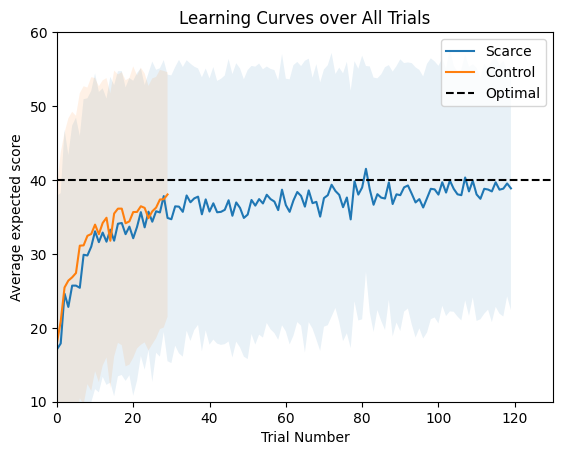

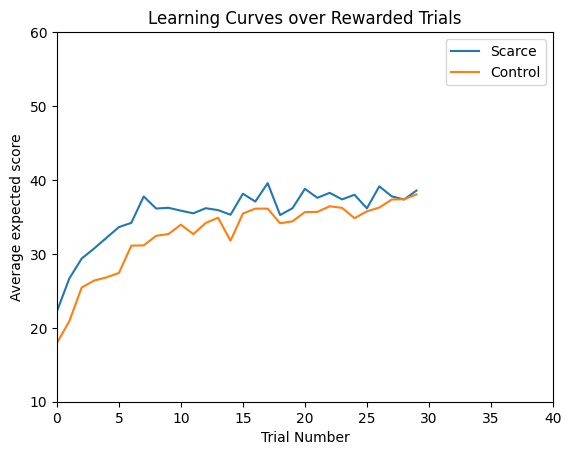

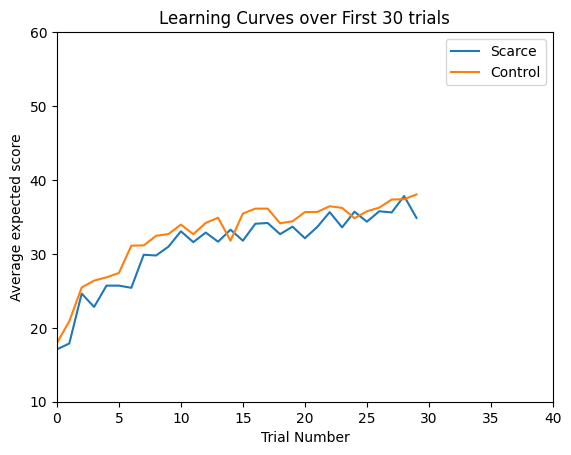

In [26]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# Taking the mean expected score over all trials 
scarce_data_all = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').mean()["expectedScores"])
scarce_data_all_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').std()["expectedScores"])
control_data = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["expectedScores"])
control_data_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').std()["expectedScores"])
scarce_data_first_30 = scarce_data_all[0:30]
scarce_data_first_30_sd = scarce_data_all_sd[0:30]

# Taking only the rewarded trials in the scarce condition
rewarded_trials_df = pd.DataFrame(columns=data_to_copy.columns)
for worker in np.unique(data_to_copy.workerId):
    workerRows = data_to_copy.loc[(data_to_copy.scarce == 1) & (data_to_copy.workerId == worker)].reset_index(drop=True)
    rewarded = workerRows.loc[workerRows.rewardsWithheld == False]
    rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))
    rewarded_trials_df = pd.concat([rewarded_trials_df,rewarded], ignore_index=True)

rewarded_trials_df['trialNumbers'] = rewarded_trials_df['trialNumbers'].astype("int64")
rewarded_trials_df['scarce'] = rewarded_trials_df['scarce'].astype("int64")
rewarded_trials_df['numRewardedTrials'] = rewarded_trials_df['numRewardedTrials'].astype("int64")
rewarded_trials_df['numUnrewardedTrials'] = rewarded_trials_df['numUnrewardedTrials'].astype("int64")
rewarded_trials_df['rewardsWithheld'] = rewarded_trials_df['rewardsWithheld'].astype("boolean")
scarce_data_rewarded = np.array(rewarded_trials_df.groupby('trialNumbers').mean()["expectedScores"])
scarce_data_rewarded_sd = np.array(rewarded_trials_df.groupby('trialNumbers').std()["expectedScores"])

plt.figure()
plt.title("Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarce")
plt.fill_between(list(range(len(scarce_data_all))), scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.fill_between(list(range(len(control_data))), control_data + control_data_sd, control_data - control_data_sd, alpha=0.1)
plt.axhline(39.97, color='k', label='Optimal', linestyle="--")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average expected score")
plt.show()

plt.figure()
plt.title("Learning Curves over Rewarded Trials")
plt.plot(list(range(len(scarce_data_rewarded))), scarce_data_rewarded, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average expected score")
plt.show()

plt.figure()
plt.title("Learning Curves over First 30 trials")
plt.plot(list(range(len(scarce_data_first_30))), scarce_data_first_30, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average expected score")
plt.show()



## Clicks

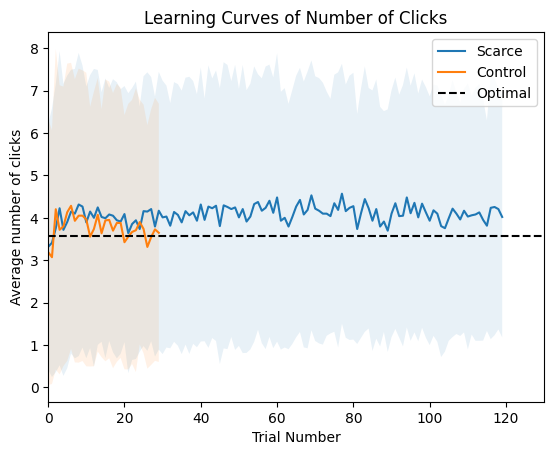

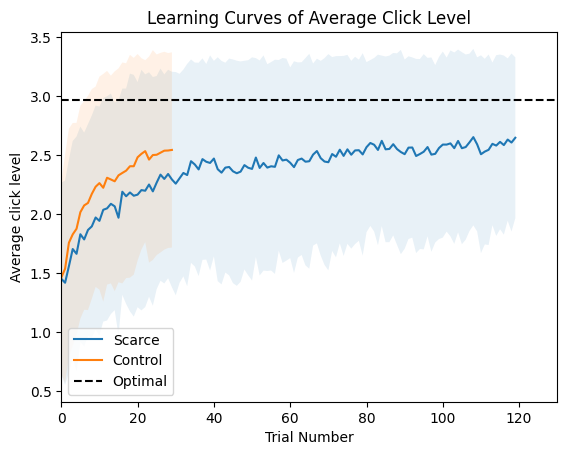

In [27]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# Taking the mean expected score over all trials 
scarce_level_all = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').mean()["avgClickLevel"])
scarce_level_all_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').std()["avgClickLevel"])
control_level_all = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["avgClickLevel"])
control_level_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').std()["avgClickLevel"])

# Taking the mean expected score over all trials 
scarce_num_all = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').mean()["numClicks"])
scarce_num_all_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').std()["numClicks"])
control_num_all = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["numClicks"])
control_num_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').std()["numClicks"])

plt.figure()
plt.title("Learning Curves of Number of Clicks")
plt.plot(list(range(len(scarce_num_all))), scarce_num_all, label="Scarce")
plt.fill_between(list(range(len(scarce_num_all))), scarce_num_all + scarce_num_all_sd, scarce_num_all - scarce_num_all_sd, alpha=0.1)
plt.plot(list(range(len(control_num_all))), control_num_all, label="Control")
plt.fill_between(list(range(len(control_num_all))), control_num_all + control_num_sd, control_num_all - control_num_sd, alpha=0.1)
plt.axhline(3.56, color='k', label='Optimal', linestyle="--")
plt.legend()
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average number of clicks")
plt.show()

plt.figure()
plt.title("Learning Curves of Average Click Level")
plt.plot(list(range(len(scarce_level_all))), scarce_level_all, label="Scarce")
plt.fill_between(list(range(len(scarce_level_all))), scarce_level_all + scarce_level_all_sd, scarce_level_all - scarce_level_all_sd, alpha=0.1)
plt.plot(list(range(len(control_level_all))), control_level_all, label="Control")
plt.fill_between(list(range(len(control_level_all))), control_level_all + control_level_sd, control_level_all - control_level_sd, alpha=0.1)
plt.axhline(2.968, color='k', label='Optimal', linestyle="--")
plt.legend()
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average click level")
plt.show()




## Strategy Scores

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_53249/1623085701.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))


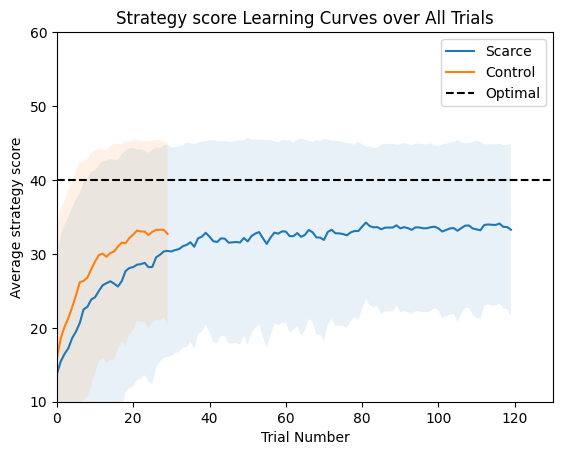

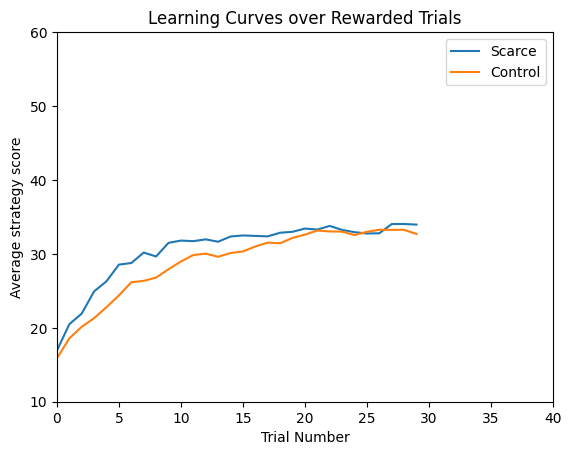

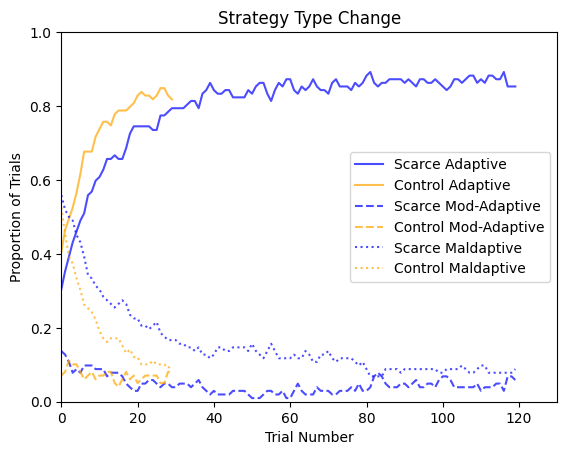

In [28]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

scarce_trial_group = data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers')
control_trial_group = data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers')

# Taking the mean expected score over all trials 
scarce_data_all = np.array(scarce_trial_group.mean()["strategyScores"])
scarce_data_all_sd = np.array(scarce_trial_group.std()["strategyScores"])
control_data = np.array(control_trial_group.mean()["strategyScores"])
control_data_sd = np.array(control_trial_group.std()["strategyScores"])

# Getting the proportions of clusters
scarce_data_adaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==0).sum()) / scarce_trial_group["cluster"].count())
control_data_adaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==0).sum()) / control_trial_group["cluster"].count())
scarce_data_modadaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==1).sum()) / scarce_trial_group["cluster"].count())
control_data_modadaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==1).sum()) / control_trial_group["cluster"].count())
scarce_data_maladaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==2).sum()) / scarce_trial_group["cluster"].count())
control_data_maladaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==2).sum()) / control_trial_group["cluster"].count())
#control_data = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["strategyScores"])
#control_data_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').std()["strategyScores"])

# Taking only the rewarded trials in the scarce condition
rewarded_trials_df = pd.DataFrame(columns=data_to_copy.columns)
for worker in np.unique(data_to_copy.workerId):
    workerRows = data_to_copy.loc[(data_to_copy.scarce == 1) & (data_to_copy.workerId == worker)].reset_index(drop=True)
    rewarded = workerRows.loc[workerRows.rewardsWithheld == False]
    rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))
    rewarded_trials_df = pd.concat([rewarded_trials_df,rewarded], ignore_index=True)

rewarded_trials_df['trialNumbers'] = rewarded_trials_df['trialNumbers'].astype("int64")
rewarded_trials_df['scarce'] = rewarded_trials_df['scarce'].astype("int64")
rewarded_trials_df['numRewardedTrials'] = rewarded_trials_df['numRewardedTrials'].astype("int64")
rewarded_trials_df['numUnrewardedTrials'] = rewarded_trials_df['numUnrewardedTrials'].astype("int64")
rewarded_trials_df['rewardsWithheld'] = rewarded_trials_df['rewardsWithheld'].astype("boolean")
scarce_data_rewarded = np.array(rewarded_trials_df.groupby('trialNumbers').mean()["strategyScores"])
scarce_data_rewarded_sd = np.array(rewarded_trials_df.groupby('trialNumbers').std()["strategyScores"])

plt.figure()
plt.title("Strategy score Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarce")
plt.fill_between(list(range(len(scarce_data_all))), scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.fill_between(list(range(len(control_data))), control_data + control_data_sd, control_data - control_data_sd, alpha=0.1)
plt.axhline(np.max(np.array(strategy_scores_control_list)[:,1], axis=0), color='k', label='Optimal', linestyle="--")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Learning Curves over Rewarded Trials")
plt.plot(list(range(len(scarce_data_rewarded))), scarce_data_rewarded, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Strategy Type Change")
alpha = 0.7
plt.plot(list(range(len(scarce_data_all))), scarce_data_adaptive, label="Scarce Adaptive", color='b',alpha=alpha)
plt.plot(list(range(len(control_data))), control_data_adaptive, label="Control Adaptive",color='orange',alpha=alpha)
plt.plot(list(range(len(scarce_data_all))), scarce_data_modadaptive, label="Scarce Mod-Adaptive", color='b',alpha=alpha, linestyle="--")
plt.plot(list(range(len(control_data))), control_data_modadaptive, label="Control Mod-Adaptive",color='orange',alpha=alpha, linestyle="--")
plt.plot(list(range(len(scarce_data_all))), scarce_data_maladaptive, label="Scarce Maldaptive", color='b',alpha=alpha, linestyle=":")
plt.plot(list(range(len(control_data))), control_data_maladaptive, label="Control Maldaptive",color='orange',alpha=alpha, linestyle=":")
plt.legend()
plt.ylim([0,1])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Proportion of Trials")
plt.show()


# 0.1 - Transforming Response Data

In [29]:
def scale_to_range(arr, lb, ub):
    return ((arr - arr.min()) / (arr.max() - arr.min())) * (ub - lb) + lb

In [30]:
# Selecting the response variable

response_vars = ['expectedScores', 'avgClickLevel', 'strategyScores']

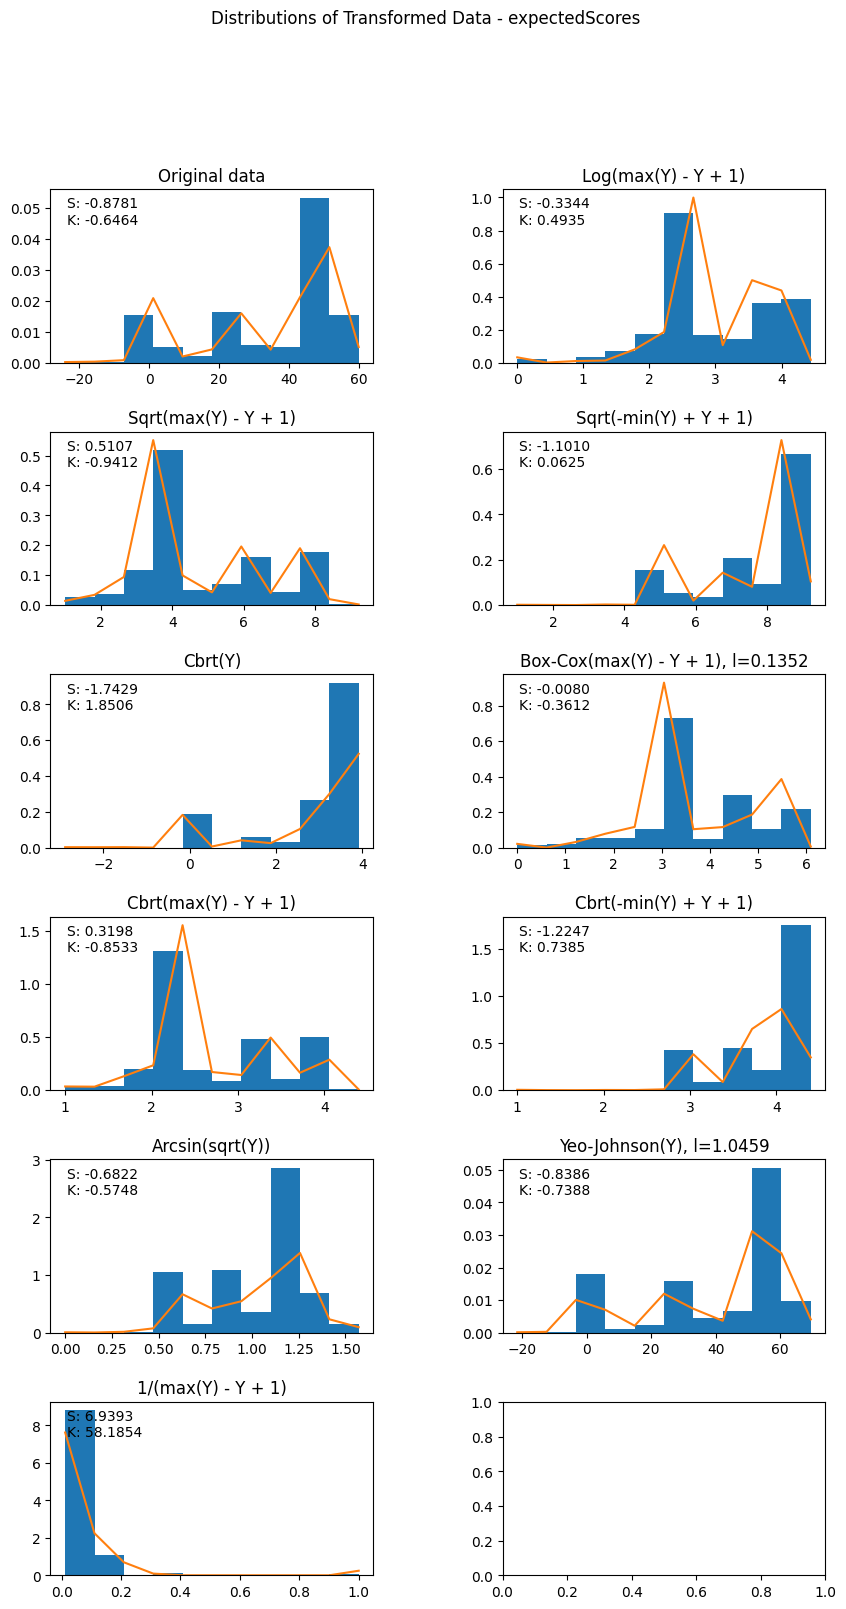

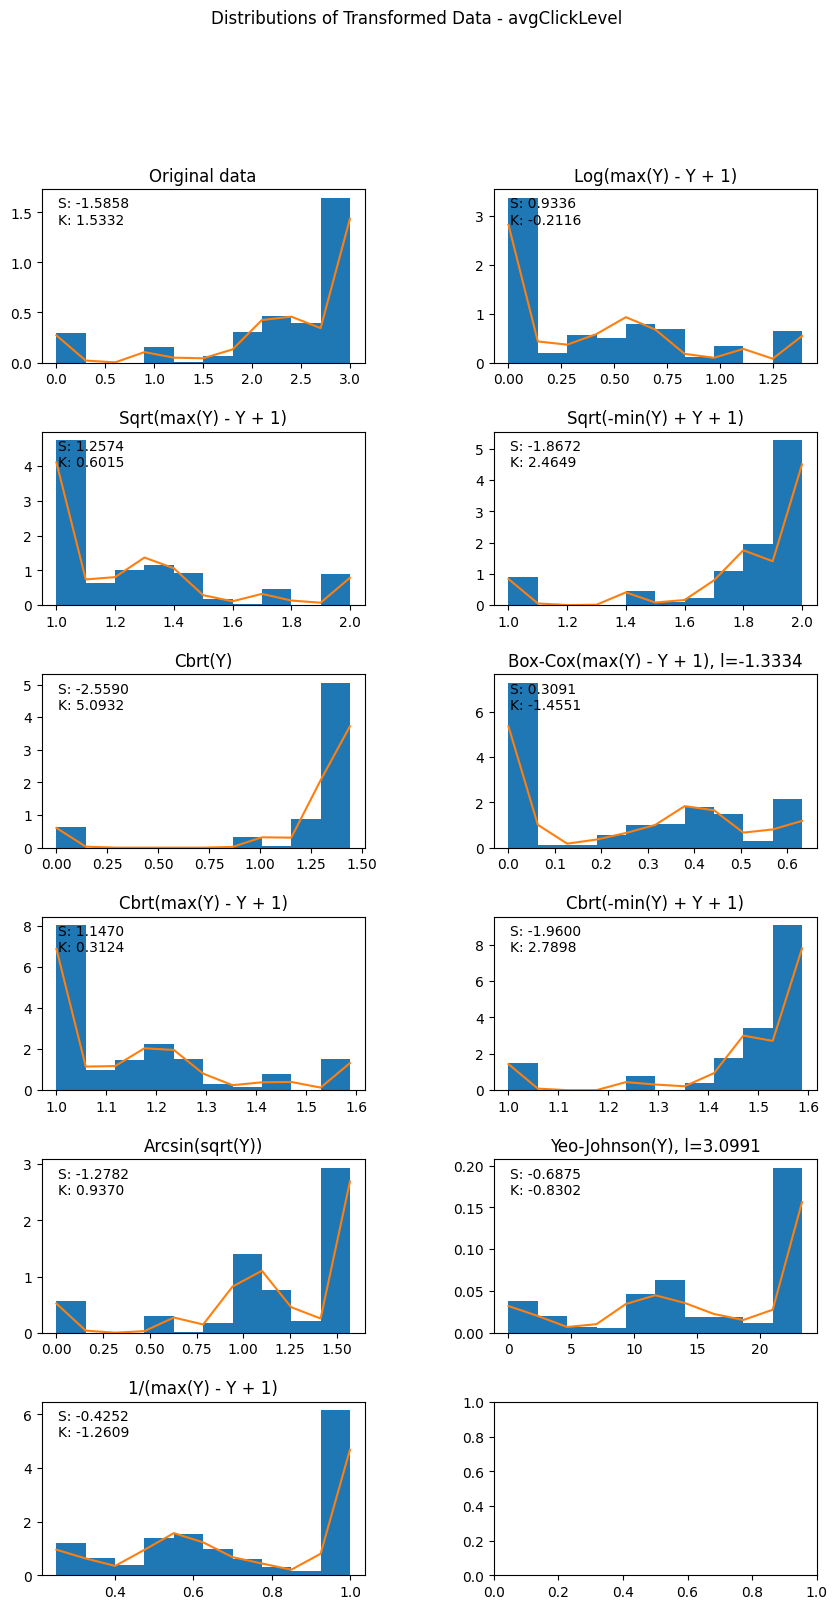

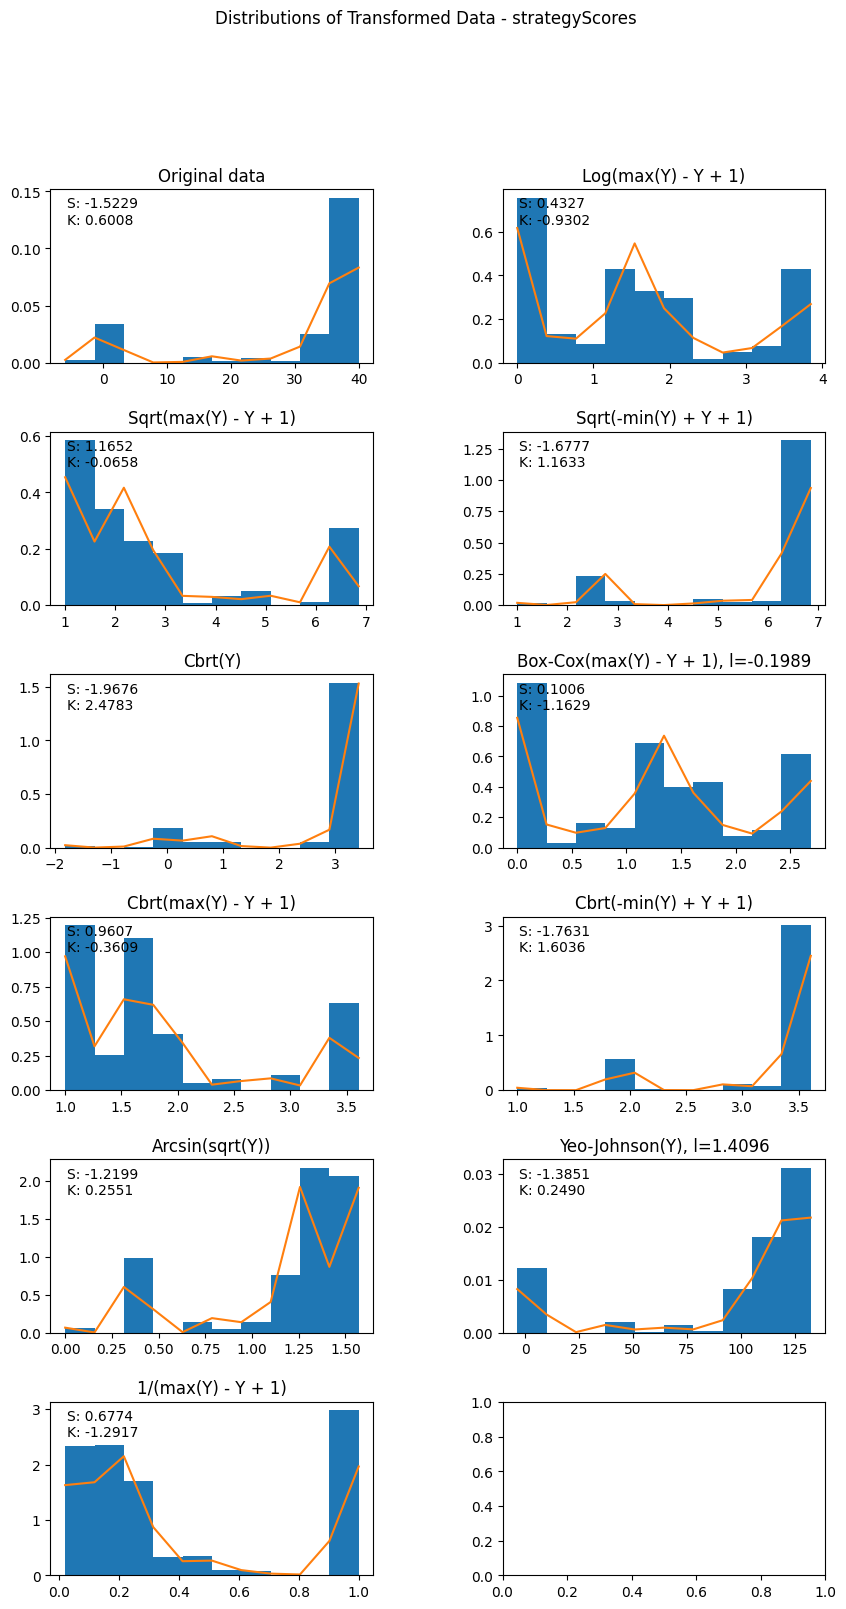

In [31]:
# Transforming the data

data_to_copy = filtered_data.copy() # or outliers_excluded
transformed_trials_df = data_to_copy.copy()
trans_list = {res: [] for res in response_vars}

for response_var in response_vars:
    

    log_transformed_trials_df = data_to_copy.copy()
    sq_transformed_trials_df = data_to_copy.copy()
    sq2_transformed_trials_df = data_to_copy.copy()
    cb_transformed_trials_df = data_to_copy.copy()
    cb2_transformed_trials_df = data_to_copy.copy()
    cb3_transformed_trials_df = data_to_copy.copy()
    arcsin_transformed_trials_df = data_to_copy.copy()
    bc_transformed_trials_df = data_to_copy.copy()
    yj_transformed_trials_df = data_to_copy.copy()
    inverse_transformed_trials_df = data_to_copy.copy()


    log_transformed_trials_df[response_var] = np.log(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq_transformed_trials_df[response_var] = np.sqrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq2_transformed_trials_df[response_var] = np.sqrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    cb_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var])
    cb2_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    cb3_transformed_trials_df[response_var] = np.cbrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    arcsin_transformed_trials_df[response_var] = np.arcsin(np.sqrt(scale_to_range(transformed_trials_df[response_var], 0, 1)))
    bc_transformed_trials_df[response_var],lam = scipy.stats.boxcox(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    #logit_transformed_trials_df[response_var] = scipy.special.logit(scale_to_range(transformed_trials_df[response_var], 0, 1))
    yj_transformed_trials_df[response_var],lam_y = scipy.stats.yeojohnson(transformed_trials_df[response_var])
    inverse_transformed_trials_df[response_var] = 1/(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])

    trans_list[response_var] = [
        (transformed_trials_df, "Original data"),
        (log_transformed_trials_df, "Log(max(Y) - Y + 1)"),
        (sq_transformed_trials_df, "Sqrt(max(Y) - Y + 1)"),
        (sq2_transformed_trials_df, "Sqrt(-min(Y) + Y + 1)"),
        (cb_transformed_trials_df, "Cbrt(Y)"),
        (bc_transformed_trials_df, "Box-Cox(max(Y) - Y + 1), l={0:0.4f}".format(lam)),
        (cb2_transformed_trials_df, "Cbrt(max(Y) - Y + 1)"),
        (cb3_transformed_trials_df, "Cbrt(-min(Y) + Y + 1)"),
        (arcsin_transformed_trials_df, "Arcsin(sqrt(Y))"),
        (yj_transformed_trials_df, "Yeo-Johnson(Y), l={0:0.4f}".format(lam_y)),
        (inverse_transformed_trials_df, "1/(max(Y) - Y + 1)")
    ]
    
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Distributions of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0][response_var]
        label = trans[1]
        skew = scipy.stats.skew(data)
        density = scipy.stats.gaussian_kde(data)
        kurtosis = scipy.stats.kurtosis(data)
        n, x, _ = ax[idx].hist(data, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nK: {1:0.4f}".format(skew, kurtosis), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

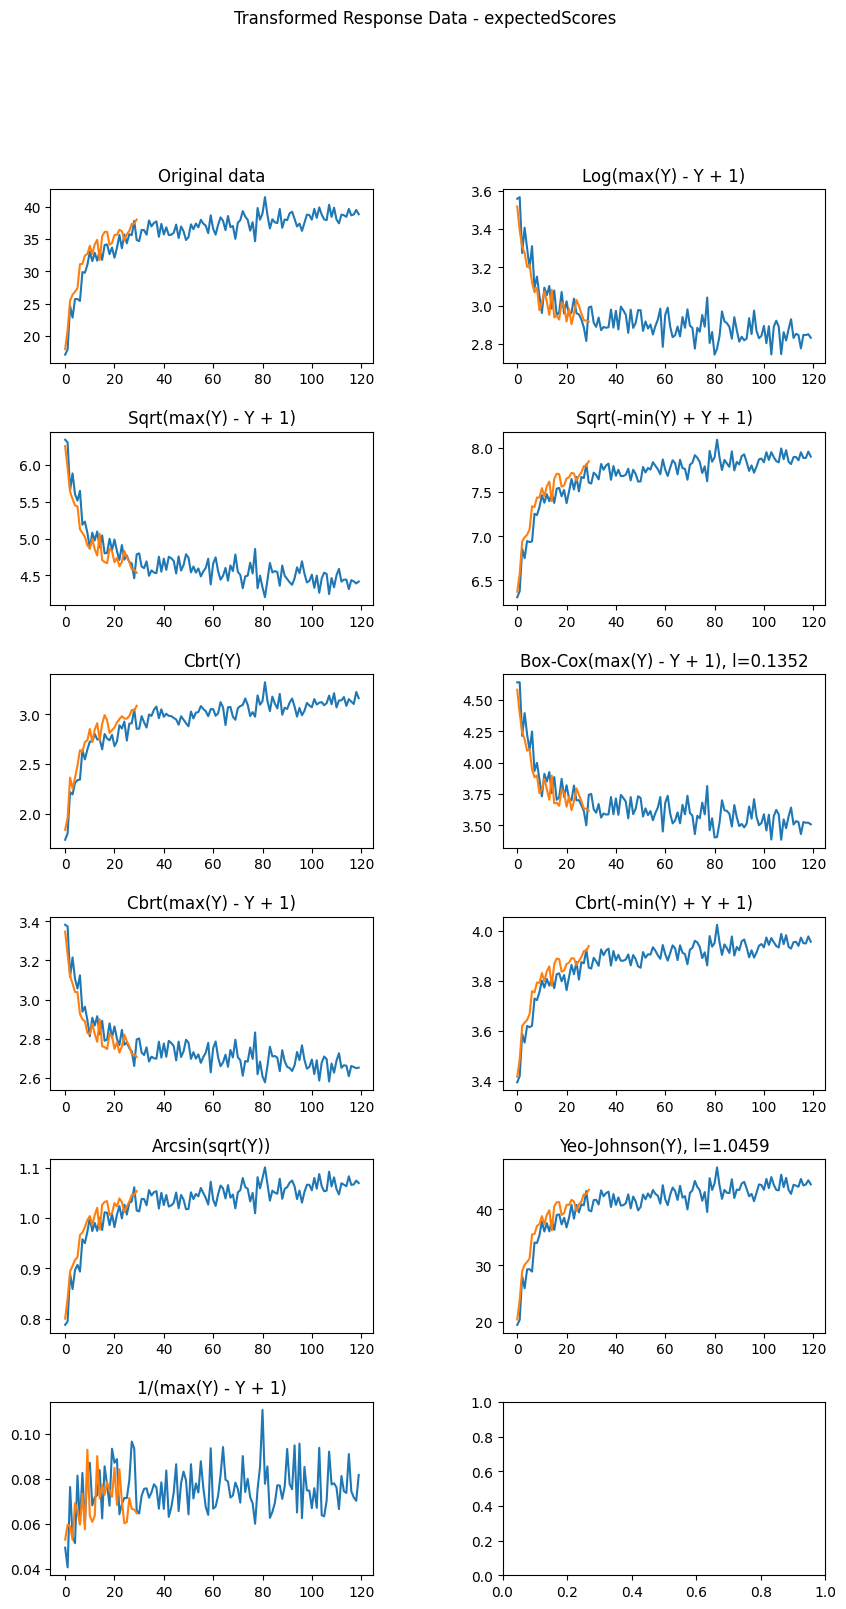

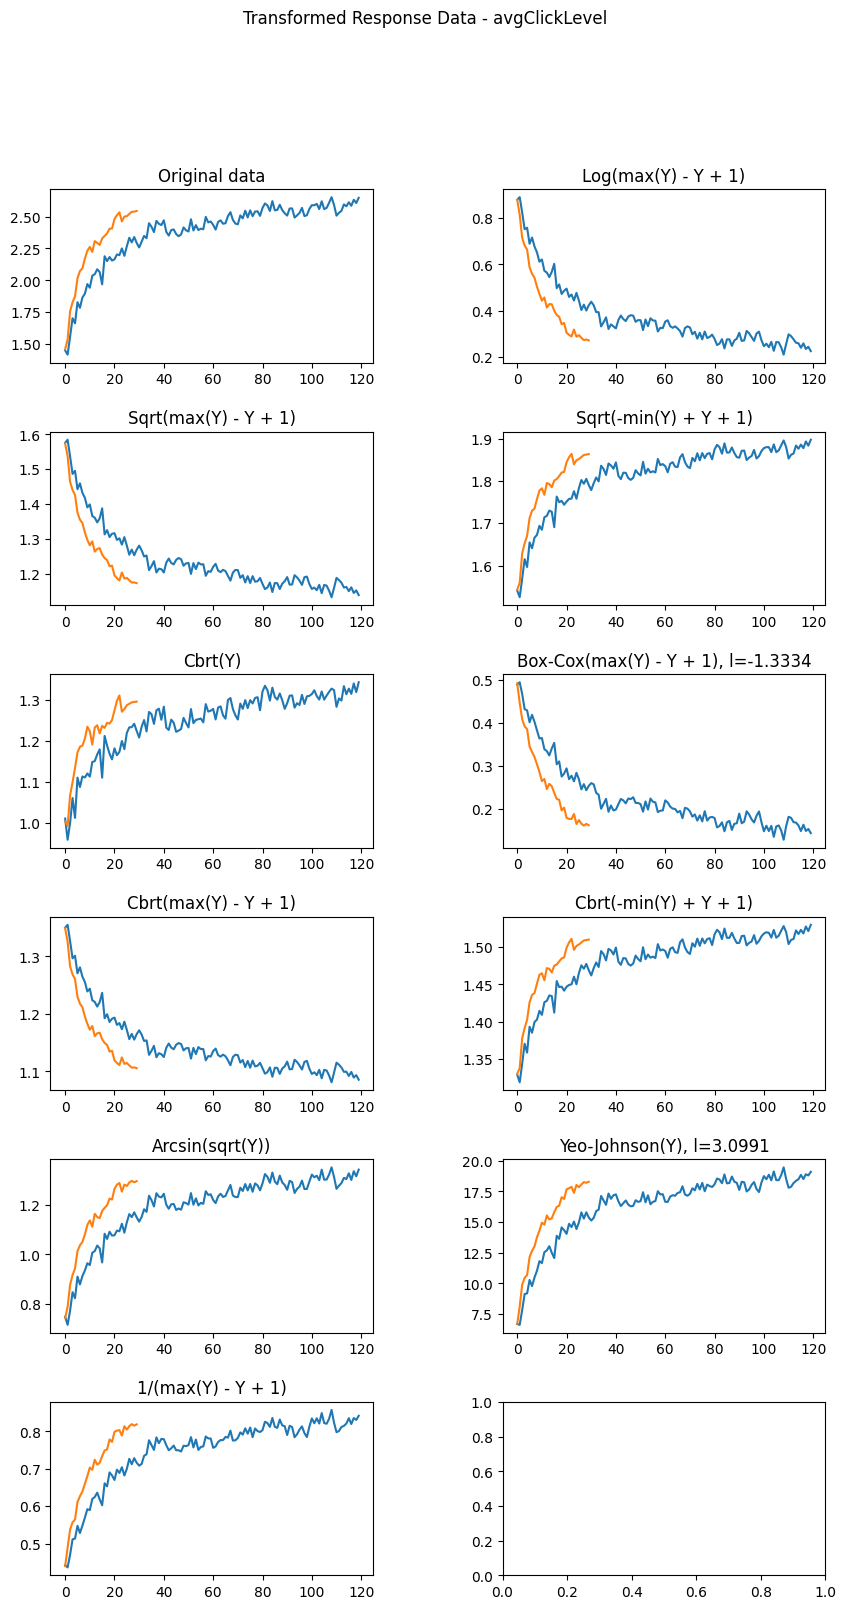

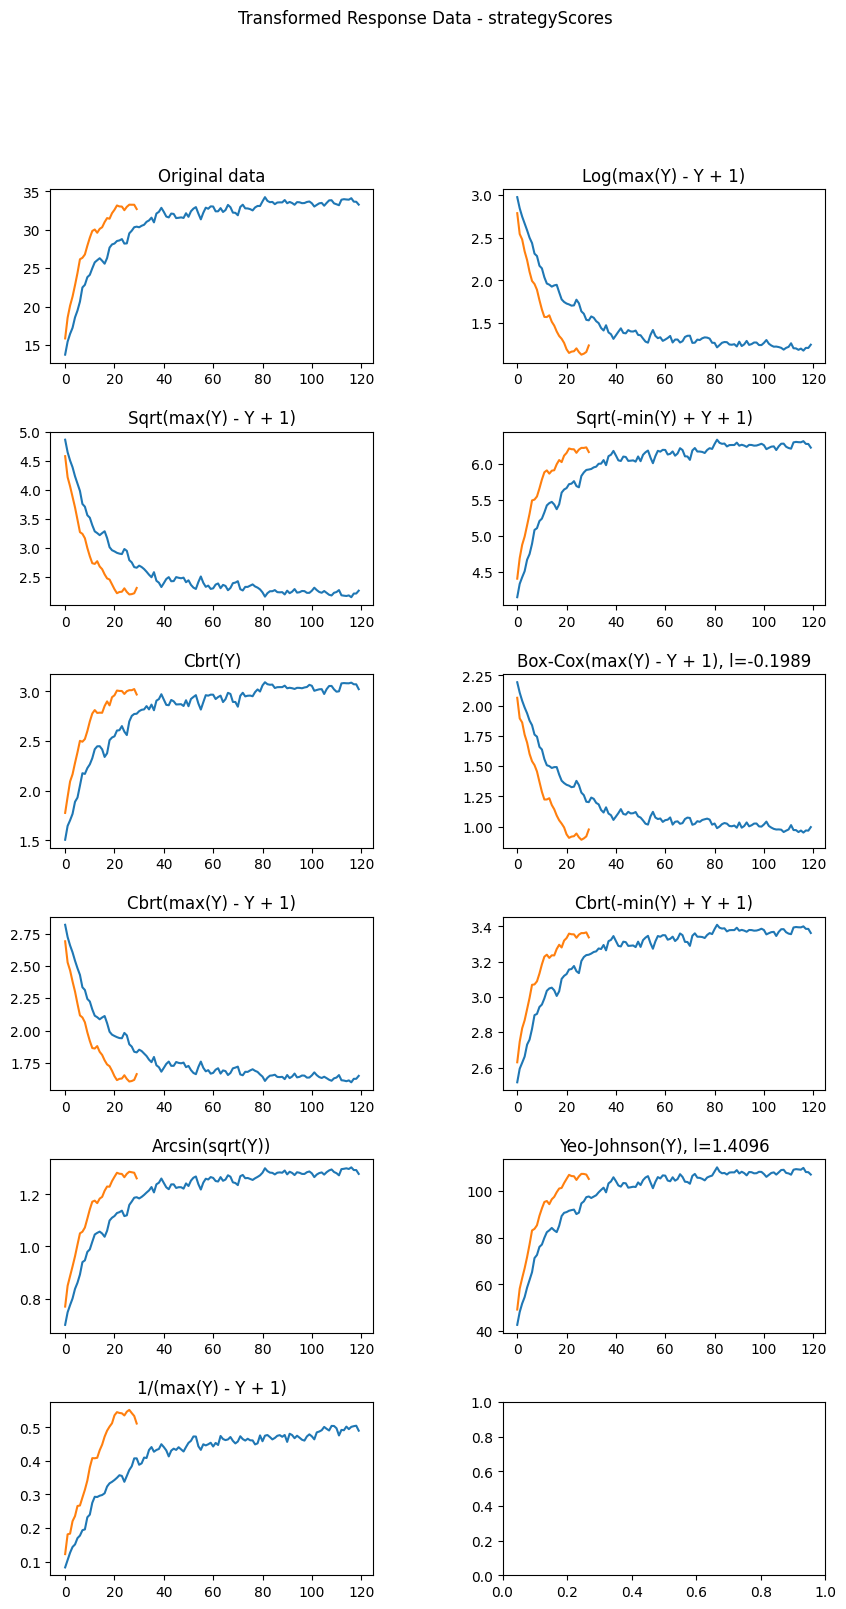

In [32]:
# Plotting the response data

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Transformed Response Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0]
        scarce = data.loc[data.scarce == 1]
        control = data.loc[data.scarce == 0]
        label = trans[1]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean()[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean()[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Scarce")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

## Linear Regression: Expected Score vs. Trial Number x Condition

In [33]:
# formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

In [34]:
# GLM Model 1 - Expected score vs. Trial number & Condition - all possible transformations

# Creating the list of data to subplot all residuals

all_residuals = {res: [] for res in response_vars}
mixed = True

for response_var in response_vars:
    formula = '{} ~ C(trialNumbers) + C(scarce)'.format(response_var);

    for idx, trans in enumerate(trans_list[response_var]):
        if mixed:
            glm = smf.mixedlm(formula=formula, data=trans[0], groups=trans[0]['workerId'])
        else:
            glm = smf.glm(formula=formula, data=trans[0])

        results = glm.fit()

        print("\n{} - {}:".format(response_var, trans[1]))
        print(results.summary())

        resids = results.resid_response if not mixed else results.resid
        normaltest = scipy.stats.normaltest(resids)
        all_residuals[response_var].append((
            resids,
            trans[0][response_var],
            trans[1],
            normaltest
        ))



expectedScores - Original data:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15210     Method:               REML          
No. Groups:         201       Scale:                187.1138      
Min. group size:    30        Log-Likelihood:       -61571.8214   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.7                                          
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               18.379    1.628 11.288 0.000 15.188 21.570
C(trialNumbers)[T.2]     1.861    1.364  1.364 0.173 -0.814  4.535
C(trialNumbers)[T.3]     7.532    1.364  5.520 0.000  4.858 10.207
C(trialNumbers)[T.4]     7.075    1.364  5.185 0.000  4.400  9.749
C(trialNumbers)[T.5]     8.756    1.364  6.4


expectedScores - Log(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15210     Method:               REML          
No. Groups:         201       Scale:                0.4105        
Min. group size:    30        Log-Likelihood:       -15328.1395   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.7                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               3.522    0.065  54.332 0.000  3.395  3.649
C(trialNumbers)[T.2]   -0.057    0.064  -0.898 0.369 -0.183  0.068
C(trialNumbers)[T.3]   -0.246    0.064  -3.852 0.000 -0.371 -0.121
C(trialNumbers)[T.4]   -0.196    0.064  -3.068 0.002 -0.321 -0.071
C(trialNumbers)[T.5]   -0.286    0.064


expectedScores - Sqrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15210     Method:               REML          
No. Groups:         201       Scale:                1.8709        
Min. group size:    30        Log-Likelihood:       -26805.4489   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.7                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               6.232    0.152  40.980 0.000  5.934  6.531
C(trialNumbers)[T.2]   -0.164    0.136  -1.204 0.229 -0.432  0.103
C(trialNumbers)[T.3]   -0.653    0.136  -4.788 0.000 -0.921 -0.386
C(trialNumbers)[T.4]   -0.587    0.136  -4.300 0.000 -0.854 -0.319
C(trialNumbers)[T.5]   -0.773    0.13


expectedScores - Sqrt(-min(Y) + Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    15210    Method:              REML          
No. Groups:          201      Scale:               0.9449        
Min. group size:     30       Log-Likelihood:      -21680.8721   
Max. group size:     120      Converged:           Yes           
Mean group size:     75.7                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               6.406    0.119 54.035 0.000  6.173  6.638
C(trialNumbers)[T.2]    0.134    0.097  1.378 0.168 -0.056  0.324
C(trialNumbers)[T.3]    0.561    0.097  5.781 0.000  0.370  0.751
C(trialNumbers)[T.4]    0.529    0.097  5.457 0.000  0.339  0.719
C(trialNumbers)[T.5]    0.642    0.097  6.625 0.0


expectedScores - Cbrt(Y):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    15210    Method:              REML          
No. Groups:          201      Scale:               0.7134        
Min. group size:     30       Log-Likelihood:      -19588.8656   
Max. group size:     120      Converged:           Yes           
Mean group size:     75.7                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               1.845    0.114 16.231 0.000  1.622  2.068
C(trialNumbers)[T.2]    0.093    0.084  1.100 0.271 -0.072  0.258
C(trialNumbers)[T.3]    0.503    0.084  5.966 0.000  0.338  0.668
C(trialNumbers)[T.4]    0.437    0.084  5.192 0.000  0.272  0.603
C(trialNumbers)[T.5]    0.548    0.084  6.503 0.000  0.383  0.7


expectedScores - Box-Cox(max(Y) - Y + 1), l=0.1352:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15210     Method:               REML          
No. Groups:         201       Scale:                0.8616        
Min. group size:    30        Log-Likelihood:       -20932.8982   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.7                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               4.580    0.097  47.381 0.000  4.391  4.770
C(trialNumbers)[T.2]   -0.093    0.093  -1.001 0.317 -0.274  0.089
C(trialNumbers)[T.3]   -0.382    0.093  -4.128 0.000 -0.564 -0.201
C(trialNumbers)[T.4]   -0.319    0.093  -3.441 0.001 -0.500 -0.137
C(trialNumbers)[T.5]   -


expectedScores - Cbrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15210     Method:               REML          
No. Groups:         201       Scale:                0.3020        
Min. group size:    30        Log-Likelihood:       -13037.8190   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.7                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               3.342    0.059  56.232 0.000  3.225  3.458
C(trialNumbers)[T.2]   -0.062    0.055  -1.123 0.261 -0.169  0.046
C(trialNumbers)[T.3]   -0.247    0.055  -4.501 0.000 -0.354 -0.139
C(trialNumbers)[T.4]   -0.216    0.055  -3.933 0.000 -0.323 -0.108
C(trialNumbers)[T.5]   -0.292    0.05

Exception ignored in: <generator object iter_fields at 0x140194a50>
Traceback (most recent call last):
  File "/Users/ssrinivas/.pyenv/versions/3.9.12/lib/python3.9/ast.py", line 251, in iter_fields
    yield field, getattr(node, field)
KeyboardInterrupt: 

KeyboardInterrupt



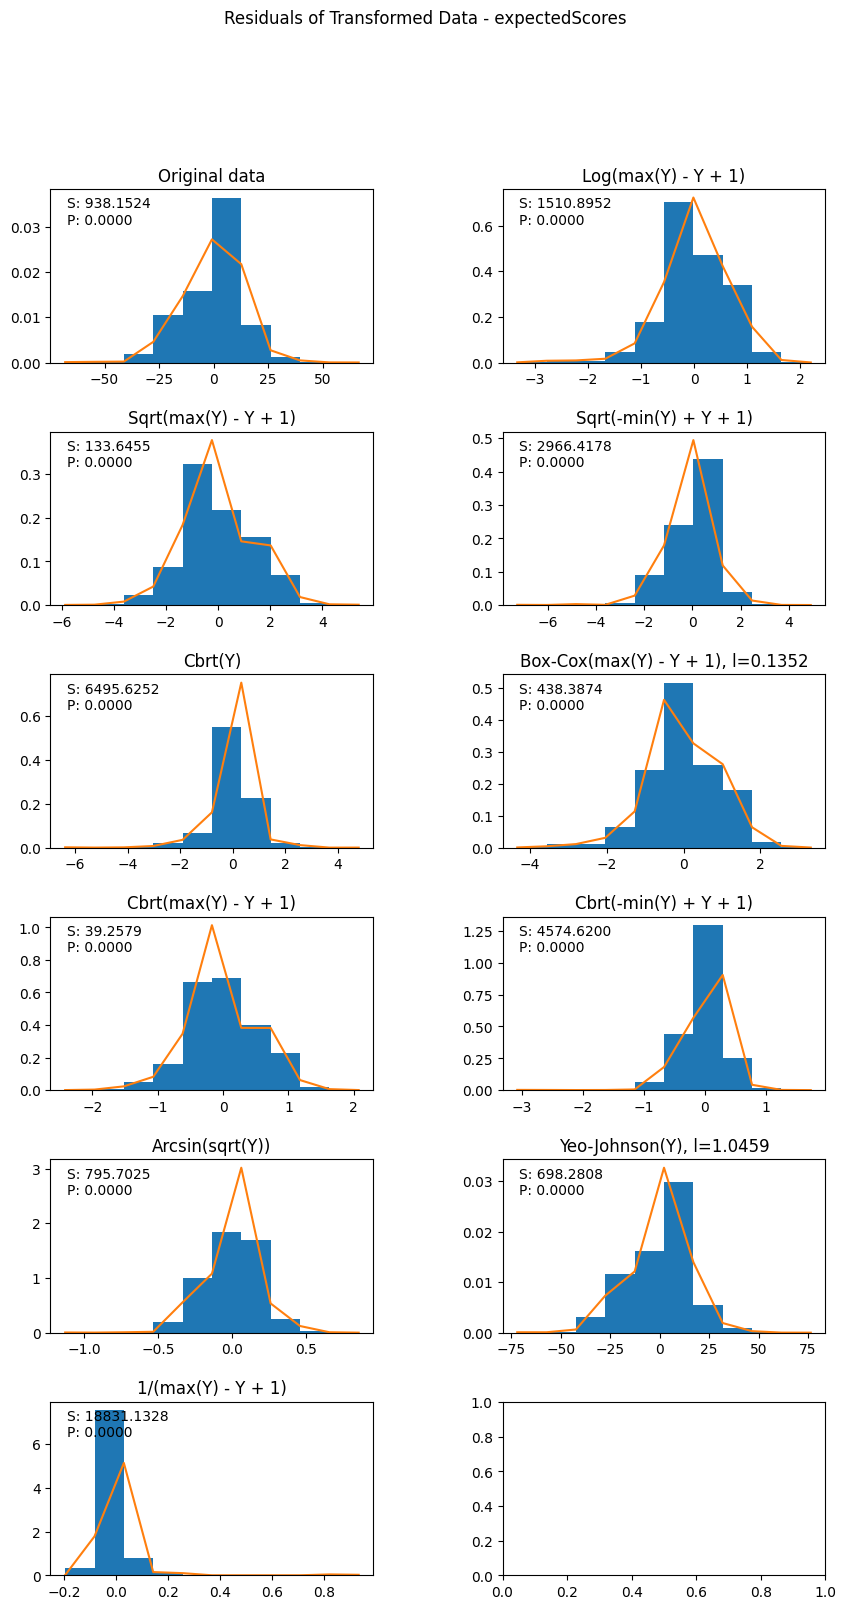

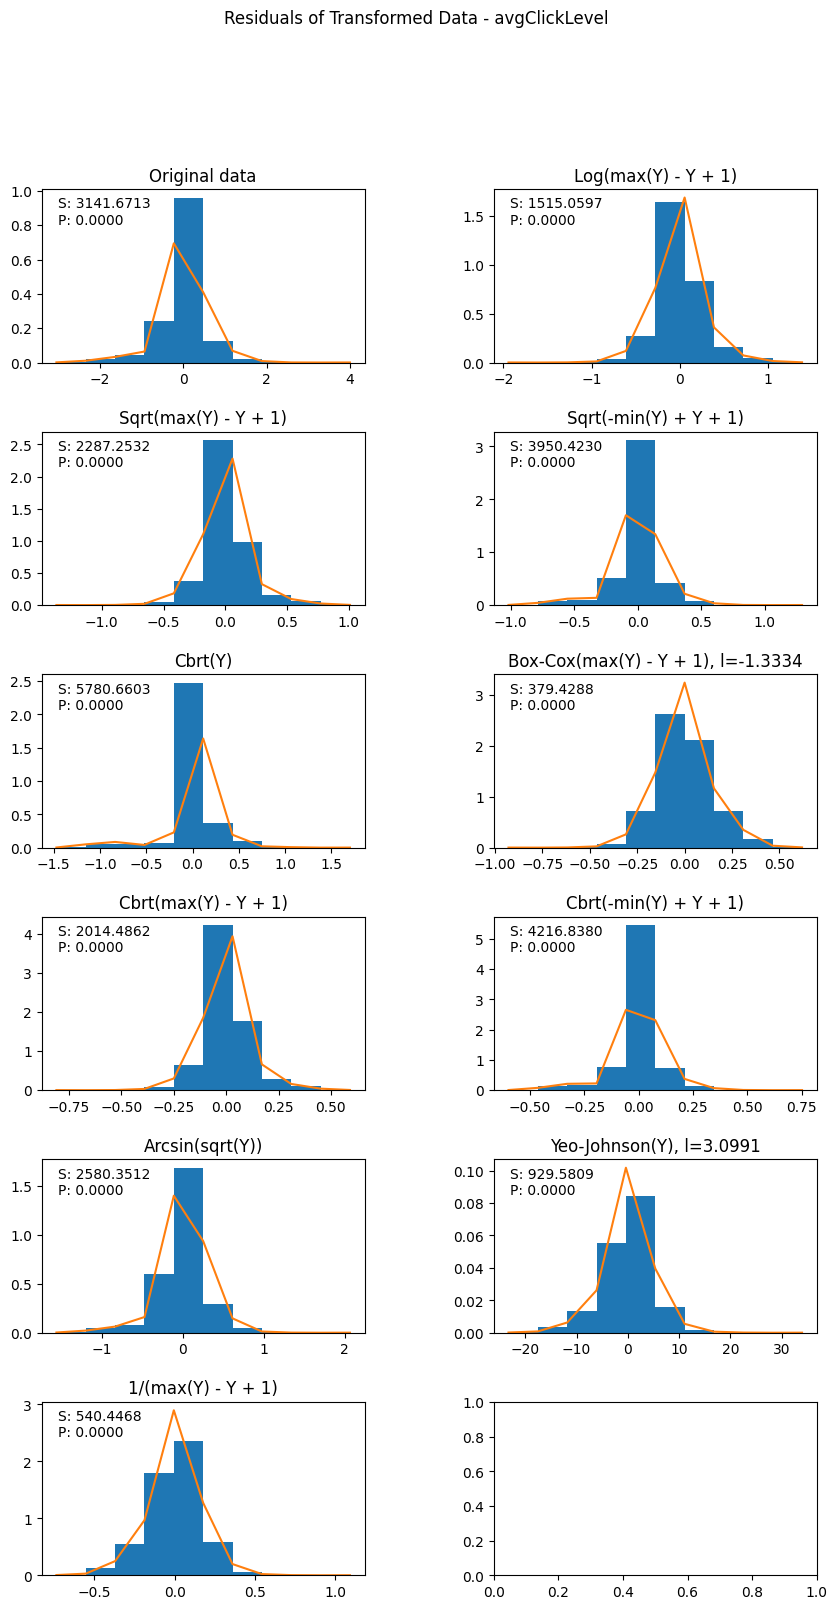

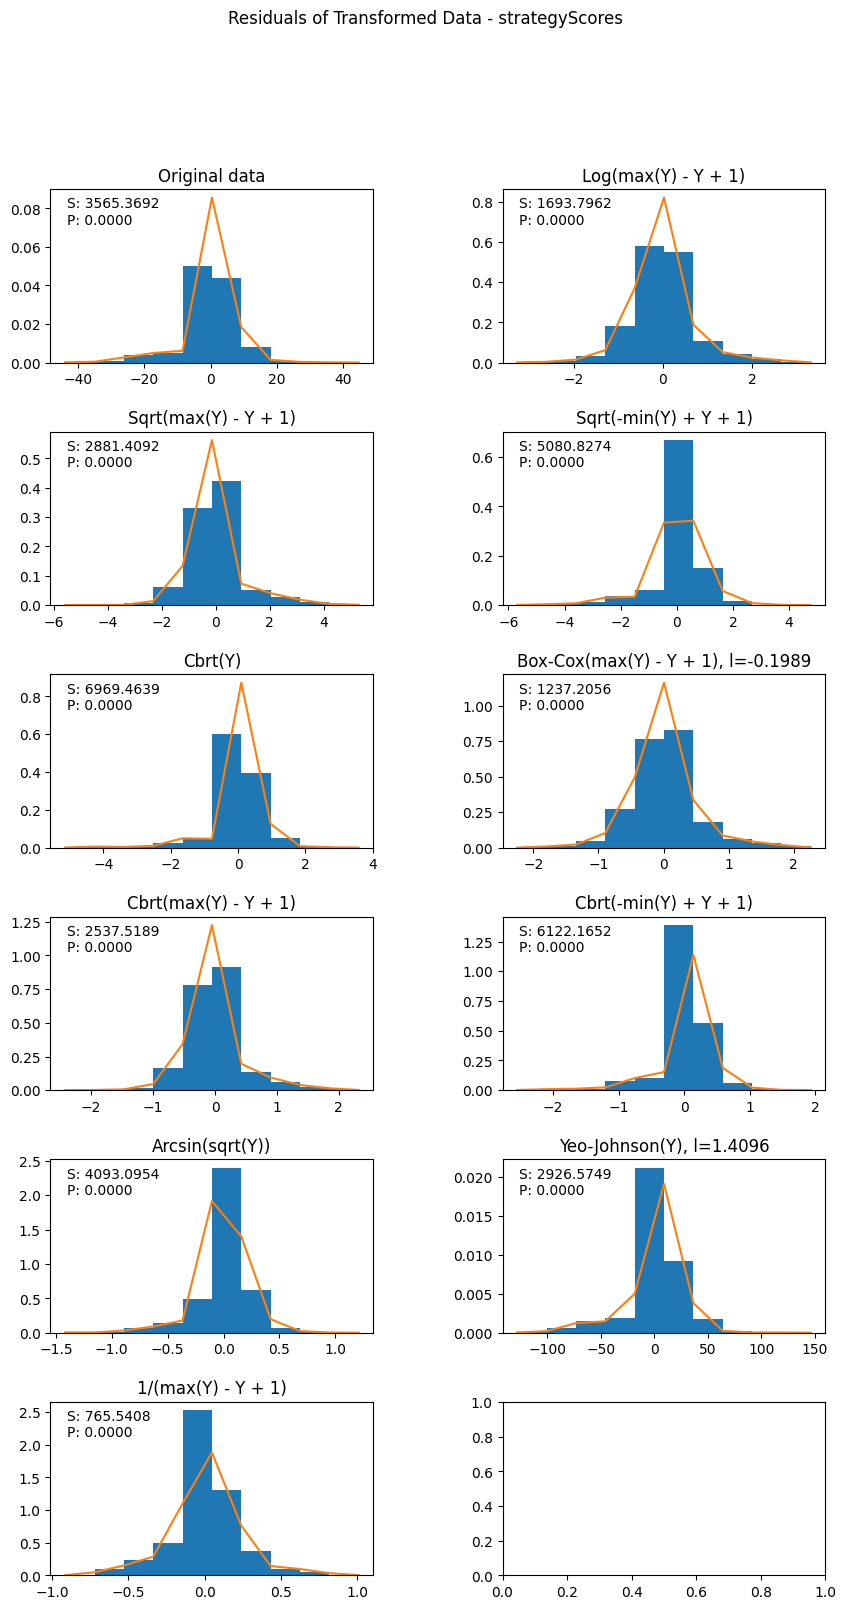

In [33]:
# Plotting residuals for all GLM Models

analysis_cols = {res: [] for res in response_vars}
highest_normality_trans = {res: "" for res in response_vars}

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(all_residuals[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(all_residuals[response_var])/2)),squeeze=False)
    plt.suptitle("Residuals of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    lowest_normality_stat = float("inf")
    for idx, trans in enumerate(all_residuals[response_var]):
        resids = trans[0]
        response_data = trans[1]
        label = trans[2]
        normaltest = trans[3]
        if normaltest.statistic < lowest_normality_stat:
            analysis_cols[response_var] = response_data
            highest_normality_trans[response_var] = label
            lowest_normality_stat = normaltest.statistic
        density = scipy.stats.gaussian_kde(resids)
        n, x, _ = ax[idx].hist(resids, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [34]:
# data which is to be used for the remainder of the analysis

analysis_data = transformed_trials_df.copy()
for response_var in response_vars:
    print("{} - {}".format(response_var, highest_normality_trans[response_var]))
    analysis_data[response_var] = analysis_cols[response_var]
    

expectedScores - Cbrt(max(Y) - Y + 1)
avgClickLevel - Box-Cox(max(Y) - Y + 1), l=-1.3334
strategyScores - 1/(max(Y) - Y + 1)


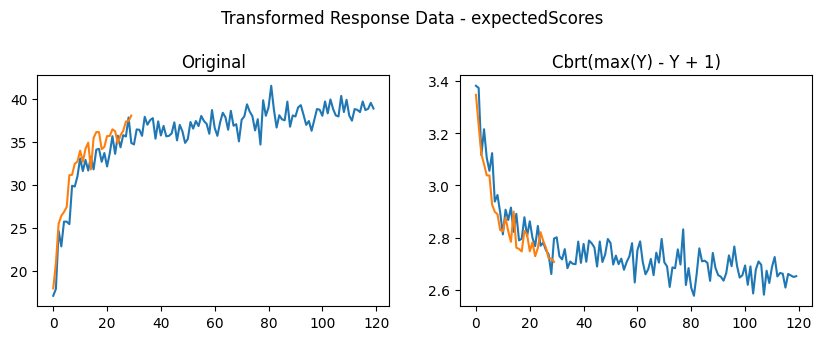

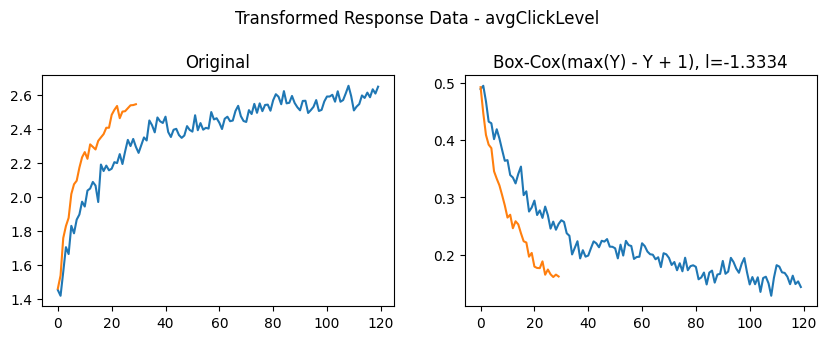

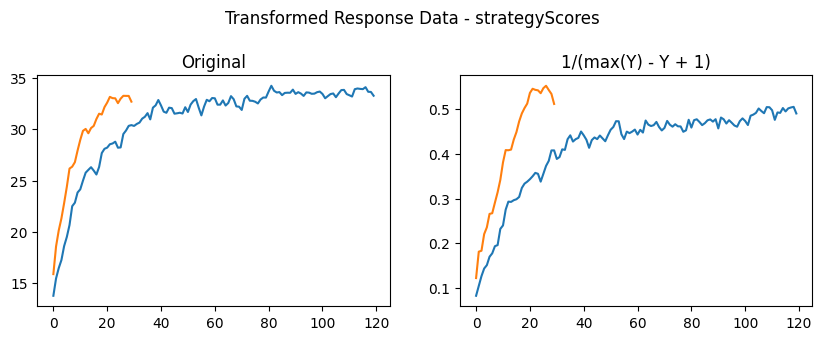

In [115]:
# Visualize transformed data for each response variable

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 3),squeeze=True)
    plt.suptitle("Transformed Response Data - {}".format(response_var),y=1.1)
    ax = ax.flatten()

    for idx, trans in enumerate([transformed_trials_df, analysis_data]):
        data = trans
        scarce = data.loc[data.scarce == 1]
        control = data.loc[data.scarce == 0]
        label = "Original" if idx == 0 else highest_normality_trans[response_var]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean()[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean()[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Scarce")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

plt.show()

In [35]:
# Scarce

scarce = analysis_data.loc[analysis_data.scarce == 1]

scarce.corr()

control = analysis_data.loc[analysis_data.scarce == 0]

control.corr()

,trialScores,expectedScores,numClicks,avgClickLevel,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,rewardsWithheld,strategyScores
trialScores,1.000000,-0.688370,0.099044,-0.401160,0.163147,NaN,0.163147,NaN,NaN,0.341890
expectedScores,-0.688370,1.000000,-0.264876,0.442958,-0.177140,NaN,-0.177140,NaN,NaN,-0.389428
numClicks,0.099044,-0.264876,1.000000,0.068665,-0.015735,NaN,-0.015735,NaN,NaN,-0.044114
avgClickLevel,-0.401160,0.442958,0.068665,1.000000,-0.356040,NaN,-0.356040,NaN,NaN,-0.719465
trialNumbers,0.163147,-0.177140,-0.015735,-0.356040,1.000000,NaN,1.000000,NaN,NaN,0.318212
scarce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
numRewardedTrials,0.163147,-0.177140,-0.015735,-0.356040,1.000000,NaN,1.000000,NaN,NaN,0.318212
numUnrewardedTrials,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rewardsWithheld,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
strategyScores,0.341890,-0.389428,-0.044114,-0.719465,0.318212,NaN,0.318212,NaN,NaN,1.000000


# 1.1.1 - Linear Regression: Finding Best Model of Learning vs. Performance

### Finding Best Model for Scarce Condition

In [36]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.scarce == 1].copy()

all_trials_mean_scarce = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_scarce = list(range(1,len(all_trials_mean_scarce)+1))

sig_bic_scores_scarce = []
scarce_plot_data = []
scarce_glm_results = []
for trialNum in range(2,60,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    # Should the model formula now include a separate regressor for just C(isPerformance)?
    two_slope_formula = "expectedScores ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    #two_slope_formula = "expectedScores ~ trialNumbers + trialNumbers:C(isPerformanceTrial)"
    one_slope_formula = "expectedScores ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
    
    # print(results_1.summary())
    
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept'] #+ results_1.params['C(isPerformanceTrial)[T.1]']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_scarce.append((trialNum, bic1))
        
    x1 = all_trial_nos_scarce[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_scarce[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3,
        i3,
        partition_1_df,
        partition_2_df
    ))
    scarce_glm_results.append((trialNum, results_1, results_2))

Partition candidates: 
[10.]


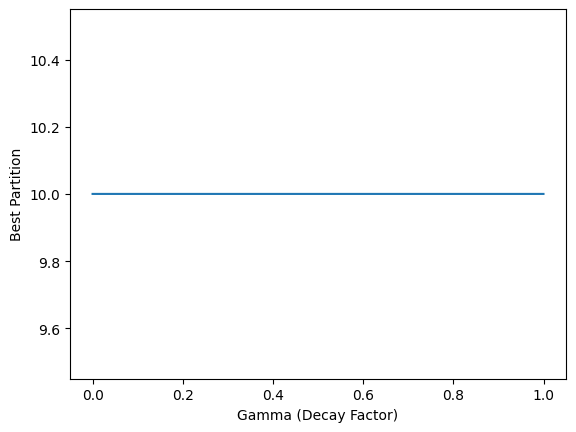

In [37]:
# Finding the best partition of all significant ones 

sig_bic_scores_scarce = np.array(sig_bic_scores_scarce)

g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Minimum bic
    partition_scores = sig_bic_scores_scarce[:,1]
    best_partition = sig_bic_scores_scarce[np.argmin(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


In [38]:
# Showing GLM results - scarce
candidate_glm_results_scarce = [data for data in scarce_glm_results if float(data[0]) in partition_candidates]

for trialNum, results_1, results_2 in candidate_glm_results_scarce:
    print("Trial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())


Trial Num: 10

Two-Slope Model:
BIC LLF: 25784.8101

BIC Deviance: -109297.9586

AIC: 25755.1603

                 Generalized Linear Model Regression Results                  
Dep. Variable:         expectedScores   No. Observations:                12240
Model:                            GLM   Df Residuals:                    12236
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.47997
Method:                          IRLS   Log-Likelihood:                -12874.
Date:                Tue, 13 Dec 2022   Deviance:                       5873.0
Time:                        11:34:15   Pearson chi2:                 5.87e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.03326
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
----

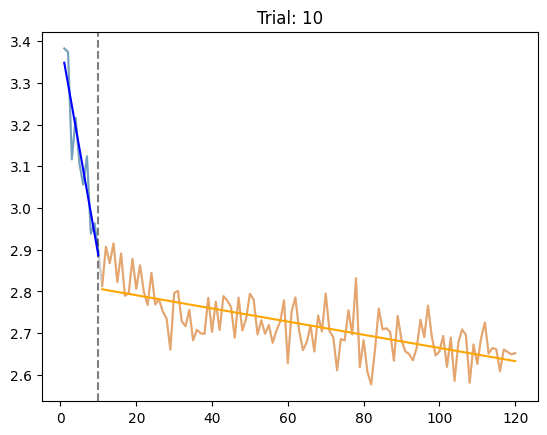

In [39]:
# Plotting candidate partitions - control
candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]
significant_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in sig_bic_scores_scarce[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_scarce
elif which_plot == "significant":
    plot_data = significant_plot_data_scarce
else:
    plot_data = scarce_plot_data
    
plot_single_slope = False
plot_two_slope = True
scatter = False
error = False

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_scarce, all_trials_mean_scarce, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)
    
    # Scatter points
    if scatter:
        plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
        plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
        
    if error:
        plt.fill_between(x1, scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [40]:
scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
scarce_learning_data = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= scarce_partition)]
scarce_performance_data = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > scarce_partition)]

# Without transformation
scarce_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= scarce_partition)]
scarce_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > scarce_partition)]

# Store the slope, intercept, etc. of the best partition
scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

### Finding Best Model for Control Condition

In [41]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For control trials
relevant_trials = test_df.loc[test_df.scarce == 0].copy()

all_trials_mean_control = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_control = list(range(1,len(all_trials_mean_control)+1))

sig_bic_scores_control = []
control_plot_data = []
control_glm_results = []
for trialNum in range(2,30,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    # Should the model formula now include a separate regressor for just C(isPerformance)?
    two_slope_formula = "expectedScores ~ trialNumbers + C(scarce) + C(isPerformanceTrial) + trialNumbers:C(isPerformanceTrial)"
    one_slope_formula = "expectedScores ~ trialNumbers + C(scarce)"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
    
    # print(results_1.summary())
    
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
#     print(bic1, bic2)
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_control.append((trialNum, bic1))
        
    x1 = all_trial_nos_control[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_control[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    control_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3, 
        i3,
        partition_1_df,
        partition_2_df
    ))
    control_glm_results.append((trialNum, results_1, results_2))

In [42]:
sig_bic_scores_control

[(2, 6540.3079192942405),
 (3, 6536.88307338648),
 (4, 6534.22594450754),
 (5, 6532.298612100105),
 (6, 6529.657847551401),
 (7, 6529.196022887138),
 (8, 6529.080149493668),
 (9, 6529.353556698063),
 (10, 6529.493566602327),
 (11, 6530.126049578883),
 (12, 6532.7131161294),
 (13, 6533.98680385983),
 (14, 6534.48043107109),
 (15, 6538.788923333683),
 (16, 6539.014293579145),
 (17, 6539.390671802845),
 (18, 6539.566189325842),
 (19, 6543.650025925391),
 (20, 6546.820753013295)]

Partition candidates: 
[8.]


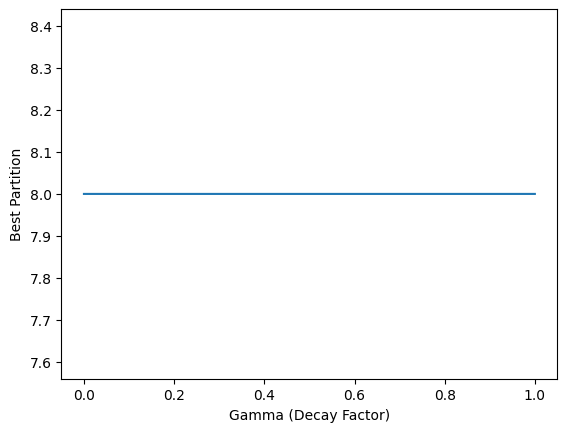

In [43]:
# Finding the best partition of all significant ones 

sig_bic_scores_control = np.array(sig_bic_scores_control)

g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Minimum bic
    partition_scores = sig_bic_scores_control[:,1]
    best_partition = sig_bic_scores_control[np.argmin(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


In [44]:
# Showing GLM results - control
candidate_glm_results_control = [data for data in control_glm_results if float(data[0]) in partition_candidates]

significant_glm_data_control = [data for data in control_glm_results if float(data[0]) in sig_bic_scores_control[:,0]]

which_results = "all" #all, significant, candidates

if which_results == "candidates":
    result_data = candidate_glm_results_control
elif which_results == "significant":
    result_data = significant_glm_data_control
else:
    result_data = control_glm_results
    
filter_results = [6, 11]
for trialNum, results_1, results_2 in result_data:
    if len(filter_results) > 0 and trialNum not in filter_results: continue
    print("\nTrial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())



Trial Num: 6

Two-Slope Model:
BIC LLF: 6529.6578

BIC Deviance: -22166.7692

AIC: 6505.6726

                 Generalized Linear Model Regression Results                  
Dep. Variable:         expectedScores   No. Observations:                 2970
Model:                            GLM   Df Residuals:                     2966
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.52269
Method:                          IRLS   Log-Likelihood:                -3248.8
Date:                Tue, 13 Dec 2022   Deviance:                       1550.3
Time:                        11:34:17   Pearson chi2:                 1.55e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04308
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
-------

In [45]:
# Showing GLM results - control
candidate_glm_results_control = [data for data in control_glm_results if float(data[0]) in partition_candidates]

for trialNum, results_1, results_2 in candidate_glm_results_control:
    print("Trial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())


Trial Num: 8

Two-Slope Model:
BIC LLF: 6529.0801

BIC Deviance: -22167.0707

AIC: 6505.0949

                 Generalized Linear Model Regression Results                  
Dep. Variable:         expectedScores   No. Observations:                 2970
Model:                            GLM   Df Residuals:                     2966
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.52259
Method:                          IRLS   Log-Likelihood:                -3248.5
Date:                Tue, 13 Dec 2022   Deviance:                       1550.0
Time:                        11:34:17   Pearson chi2:                 1.55e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04328
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
--------

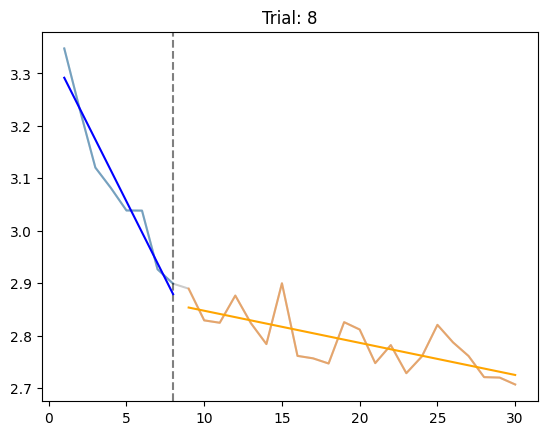

In [46]:
# Plotting candidate partitions - scarce
candidate_plot_data_control = [data for data in control_plot_data if float(data[0]) in partition_candidates]
significant_plot_data_control = [data for data in control_plot_data if float(data[0]) in sig_bic_scores_control[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_control
elif which_plot == "significant":
    plot_data = significant_plot_data_control
else:
    plot_data = control_plot_data
    
plot_single_slope = False
plot_two_slope = True
scatter = False

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_control, all_trials_mean_control, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)
    
    # Scatter points
    if scatter:
        plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
        plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [47]:
control_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
control_learning_data = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers <= control_partition)]
control_performance_data = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers > control_partition)]

# Without transformation
control_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers <= control_partition)]
control_performance_data_orig = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers > control_partition)]

# Store the slope, intercept, etc. of the best partition
control_partition_plot_data = [data for data in candidate_plot_data_control if data[0] == control_partition][0]

# 1.2 - Linear Regression: Response Var vs. Trial Number x Condition

In [116]:
# Select the response variable for this analysis

response_var = "strategyScores"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [117]:
# Flag to compare entire performance data or only upto 30 trials, where both conditions are comparable

compare_all = False
num_max_trials = min(
    analysis_data[analysis_data.scarce==1].trialNumbers.max(),
    analysis_data[analysis_data.scarce==0].trialNumbers.max()
)

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    strategyScores
No. Observations:     1812       Method:                REML          
No. Groups:           201        Scale:                 0.0207        
Min. group size:      8          Log-Likelihood:        630.8156      
Max. group size:      10         Converged:             Yes           
Mean group size:      9.0                                             
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.120    0.024  5.112 0.000  0.074  0.167
C(scarce)[T.1]              -0.044    0.033 -1.352 0.176 -0.108  0.020
trialNumbers                 0.022    0.002 10.002 0.000  0.018  0.027
trialNumbers:C(scarce)[T.1] -0.008    0.003 -2.755 0.006 -0.013 -0.002
Group Var              

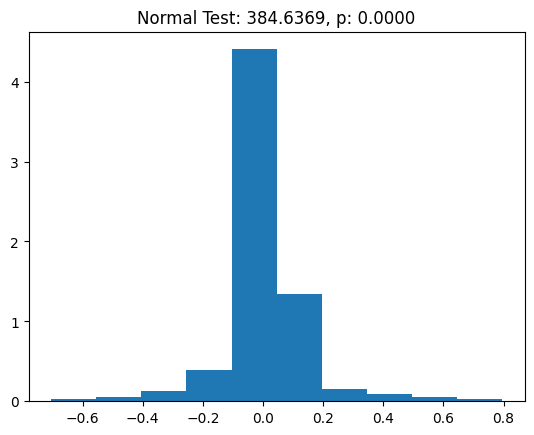

In [118]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)
#learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
#learning_df = control_learning_data

if not compare_all:
    learning_df = learning_df.loc[learning_df.trialNumbers <= num_max_trials]

formula = '{} ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

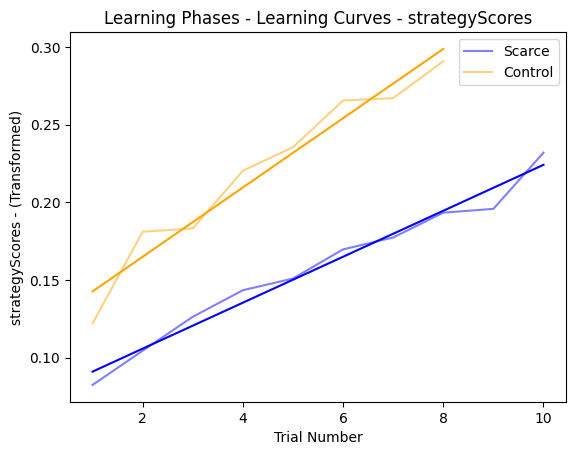

In [119]:
# Plotting the data of both learning phases

x1 = control_partition_plot_data[1]
x2 = scarce_partition_plot_data[1]
y1 = learning_df[learning_df.scarce==0].groupby("trialNumbers").mean()[response_var]
y2 = learning_df[learning_df.scarce==1].groupby("trialNumbers").mean()[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(scarce)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(scarce)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Scarce")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                 Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    strategyScores
No. Observations:      4218       Method:                REML          
No. Groups:            201        Scale:                 46.7599       
Min. group size:       20         Log-Likelihood:        -14533.6619   
Max. group size:       22         Converged:             Yes           
Mean group size:       21.0                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    26.058    1.402 18.583 0.000 23.309 28.806
C(scarce)[T.1]               -4.566    1.992 -2.292 0.022 -8.471 -0.661
trialNumbers                  0.271    0.023 11.733 0.000  0.226  0.316
trialNumbers:C(scarce)[T.1]   0.026    0.035  0.743 0.458 -0.043  0.095
Group Var

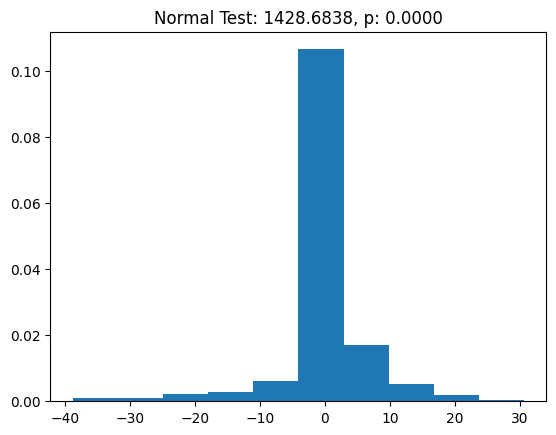

In [120]:
# Performance Phase

use_orig = True

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

# performance_df = scarce_performance_data

if not compare_all:
    performance_df = performance_df.loc[performance_df.trialNumbers <= num_max_trials]
    
formula = '{} ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

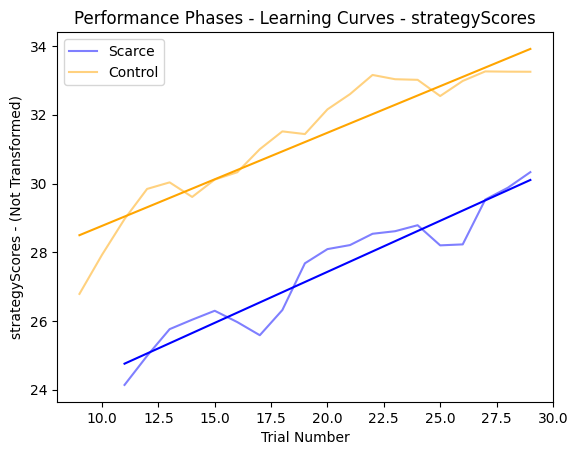

In [121]:
# Plotting the data of both performance phases together

x1 = control_partition_plot_data[2]
x2 = scarce_partition_plot_data[2]
y1 = performance_df[performance_df.scarce==0].groupby("trialNumbers").mean()[response_var]
y2 = performance_df[performance_df.scarce==1].groupby("trialNumbers").mean()[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(scarce)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(scarce)[T.1]']

if not compare_all:
    end_index = np.where(x1 == num_max_trials)[0]
    if len(end_index) > 0:
        end_index = end_index[0]
        x1 = x1[0:end_index]
        y1 = y1[0:end_index]
    
    end_index = np.where(x2 == num_max_trials)[0]
    if len(end_index) > 0:
        end_index = end_index[0]
        x2 = x2[0:end_index]
        y2 = y2[0:end_index]
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Scarce")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 1.3 - Linear Regression: Response Var vs. Num Rewarded Trials

In [144]:
# Select the response variable for this analysis

response_var = "avgClickLevel"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [145]:
# Flag to compare entire performance data or only upto 30 trials, where both conditions are comparable

compare_all = True
num_max_trials = min(
    analysis_data[analysis_data.scarce==1].trialNumbers.max(),
    analysis_data[analysis_data.scarce==0].trialNumbers.max()
)

                   Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      avgClickLevel
No. Observations:       1812         Method:                  REML         
No. Groups:             201          Scale:                   0.3098       
Min. group size:        8            Log-Likelihood:          -1800.2611   
Max. group size:        10           Converged:               Yes          
Mean group size:        9.0                                                
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         1.499    0.081 18.470 0.000  1.340  1.658
C(scarce)[T.1]                   -0.057    0.113 -0.507 0.612 -0.279  0.164
numRewardedTrials                 0.095    0.009 10.950 0.000  0.078  0.111
numRewardedTrials:C(scarce)[T.1

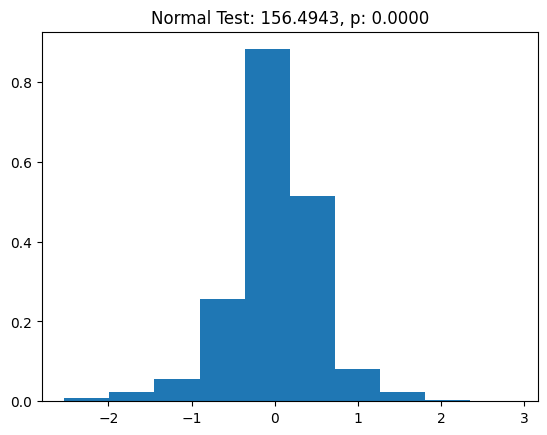

In [146]:
# Learning Phase 

use_orig = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

if not compare_all:
    learning_df = learning_df.loc[learning_df.trialNumbers <= num_max_trials]
    
formula = '{} ~ numRewardedTrials + C(scarce) + numUnrewardedTrials + numRewardedTrials:C(scarce)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results_learning = glm.fit()

print(results_learning.summary())
resids = results_learning.resid_response if not mixed else results_learning.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [147]:
# comparing coefficients using contrasts

# between conditions
# H_a = numRewardedTrials - numUnrewardedTrials > 0
print("H_a = numRewardedTrials - numUnrewardedTrials > 0")
r = np.zeros_like(results_learning.params)
r[list(results_learning.params.index).index("numRewardedTrials")] = 1
r[list(results_learning.params.index).index("numUnrewardedTrials")] = -1

print(results_learning.t_test(np.expand_dims(r[:-1], axis=0)))
print(results_learning.f_test(r))
print(results_learning.wald_test(r))

# within scarce condition
# H_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0
print("\nH_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0")
r = np.zeros_like(results_learning.params)
r[list(results_learning.params.index).index("numRewardedTrials")] = 1
r[list(results_learning.params.index).index("numRewardedTrials:C(scarce)[T.1]")] = 1
r[list(results_learning.params.index).index("numUnrewardedTrials")] = -1
print(results_learning.t_test(np.expand_dims(r[:-1], axis=0)))
print(results_learning.f_test(r))
print(results_learning.wald_test(r))

H_a = numRewardedTrials - numUnrewardedTrials > 0
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0302      0.014      2.220      0.026       0.004       0.057
<F test: F=4.926760741712914, p=0.026567567555140715, df_denom=1.81e+03, df_num=1>
<Wald test (chi2): statistic=[[4.92676074]], p-value=0.026443841990393038, df_denom=1>

H_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0142      0.031     -0.461      0.645      -0.074       0.046
<F test: F=0.21277209159607552, p=0.6446588054382131, df_denom=

/Volumes/DataDrive/mcl-scarcity-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/Volumes/DataDrive/mcl-scarcity-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


                   Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      avgClickLevel
No. Observations:       13398        Method:                  REML         
No. Groups:             201          Scale:                   0.2341       
Min. group size:        22           Log-Likelihood:          -9779.2095   
Max. group size:        110          Converged:               Yes          
Mean group size:        66.7                                               
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         2.065    0.080 25.717 0.000  1.907  2.222
C(scarce)[T.1]                    0.070    0.109  0.640 0.522 -0.144  0.283
numRewardedTrials                 0.018    0.002 11.005 0.000  0.015  0.021
numRewardedTrials:C(scarce)[T.1

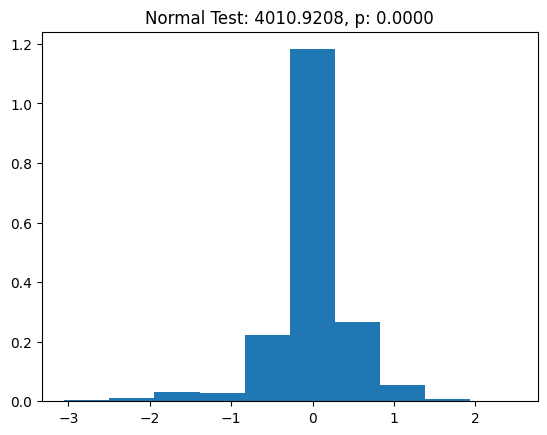

In [150]:
# Performance phase

use_orig = True

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

if not compare_all:
    performance_df = performance_df.loc[performance_df.trialNumbers <= num_max_trials]
    
formula = '{} ~ numRewardedTrials + C(scarce) + numUnrewardedTrials + numRewardedTrials:C(scarce)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results_performance = glm.fit()

print(results_performance.summary())
resids = results_performance.resid_response if not mixed else results_performance.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [151]:
# comparing coefficients using contrasts

# between conditions
# H_a = numRewardedTrials - numUnrewardedTrials > 0
print("H_a = numRewardedTrials - numUnrewardedTrials > 0")
r = np.zeros_like(results_performance.params)
r[list(results_performance.params.index).index("numRewardedTrials")] = 1
r[list(results_performance.params.index).index("numUnrewardedTrials")] = -1

print(results_performance.t_test(np.expand_dims(r[:-1], axis=0)))
print(results_performance.f_test(r))
print(results_performance.wald_test(r))

# within scarce condition
# H_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0
print("\nH_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0")
r = np.zeros_like(results_performance.params)
r[list(results_performance.params.index).index("numRewardedTrials")] = 1
r[list(results_performance.params.index).index("numRewardedTrials:C(scarce)[T.1]")] = 1
r[list(results_performance.params.index).index("numUnrewardedTrials")] = -1
print(results_performance.t_test(np.expand_dims(r[:-1], axis=0)))
print(results_performance.f_test(r))
print(results_performance.wald_test(r))

H_a = numRewardedTrials - numUnrewardedTrials > 0
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0198      0.002      9.809      0.000       0.016       0.024
<F test: F=96.21718573669858, p=1.2270292693761344e-22, df_denom=1.34e+04, df_num=1>
<Wald test (chi2): statistic=[[96.21718574]], p-value=1.0294738190797514e-22, df_denom=1>

H_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0250      0.005      5.243      0.000       0.016       0.034
<F test: F=27.48938556727123, p=1.6036187076511517e-07, df

/Volumes/DataDrive/mcl-scarcity-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/Volumes/DataDrive/mcl-scarcity-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


# 1.4 - Independent Samples T-test

In [63]:
# Select the response variable for this analysis

response_var = "strategyScores"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [64]:
# Flag to compare entire performance data or only upto 30 trials, where both conditions are comparable

compare_all = False
num_max_trials = min(
    analysis_data[analysis_data.scarce==1].trialNumbers.max(),
    analysis_data[analysis_data.scarce==0].trialNumbers.max()
)

In [65]:
use_transformed = True

if not compare_all:
    control_performance_data = control_performance_data.loc[control_performance_data.trialNumbers <= num_max_trials]
    scarce_performance_data = scarce_performance_data.loc[scarce_performance_data.trialNumbers <= num_max_trials]

if use_transformed:
    # Using the transformed data divided into phases
    control_averages = control_performance_data.groupby('workerId').mean()
    scarce_averages = scarce_performance_data.groupby('workerId').mean()
else:
    # Using the original data divided into phases
    control_averages = control_performance_data_orig.groupby('workerId').mean()
    scarce_averages = scarce_performance_data_orig.groupby('workerId').mean()
    

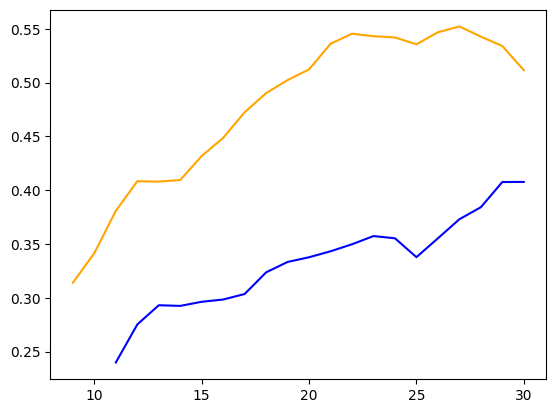

In [66]:
plt.figure()
plt.plot(np.sort(np.unique(control_performance_data.trialNumbers)), control_performance_data.groupby('trialNumbers').mean()[response_var], color='orange')
plt.plot(np.sort(np.unique(scarce_performance_data.trialNumbers)), scarce_performance_data.groupby('trialNumbers').mean()[response_var], color='b')
plt.show()

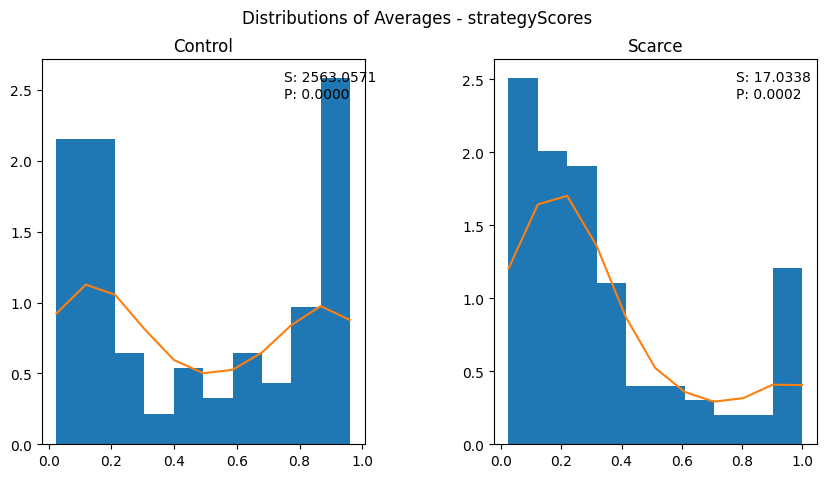

In [67]:

# Plotting normality for both groups

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5),squeeze=False)
plt.suptitle("Distributions of Averages - {}".format(response_var))
ax = ax.flatten()

for idx, group in enumerate([(control_averages, "Control"), (scarce_averages, "Scarce")]):
    data = group[0][response_var]
    label = group[1]
    normaltest = scipy.stats.normaltest(data)
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.75,0.9, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [68]:
# Perform independent T-test if data is normal


two = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='two-sided')
less = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='less')
greater = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='greater')

print("Response Variable: {}".format(response_var))
print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Scarce < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Scarce > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Response Variable: strategyScores
Two-Sided:
	Statistic: -3.104
	P-value: 0.0021863285073249607
Scarce < Control:
	Statistic: -3.104
	P-value: 0.0010931642536624803
Scarce > Control:
	Statistic: -3.104
	P-value: 0.9989068357463375


In [69]:
# Perform Mann-Whitney U test if data is not normal

two = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='two-sided')
less = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='less')
greater = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='greater')

print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Scarce < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Scarce > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Two-Sided:
	Statistic: 4133.500
	P-value: 0.02639068526349696
Scarce < Control:
	Statistic: 4133.500
	P-value: 0.01319534263174848
Scarce > Control:
	Statistic: 4133.500
	P-value: 0.986886723775992


# 1.5 - GLM Strategy Proportions

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/2031249079.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))


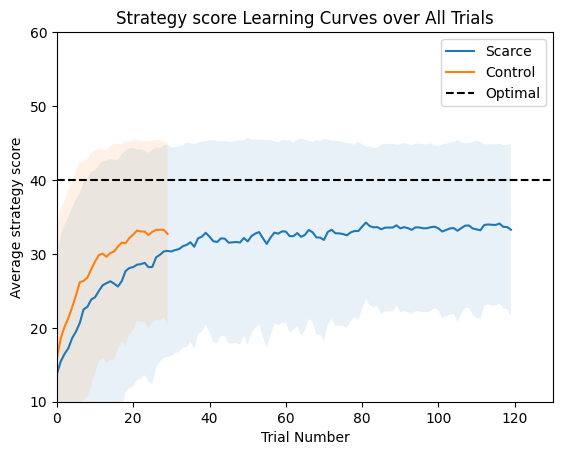

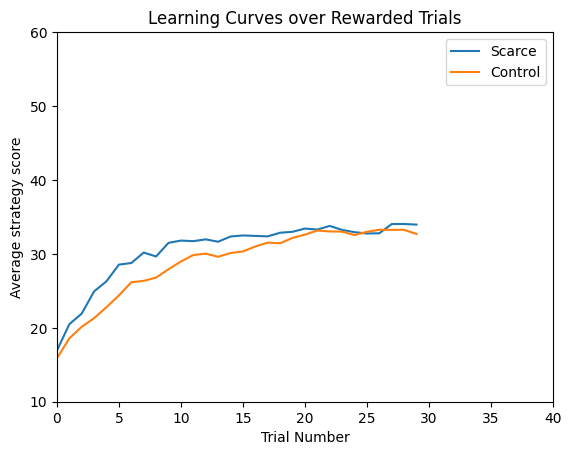

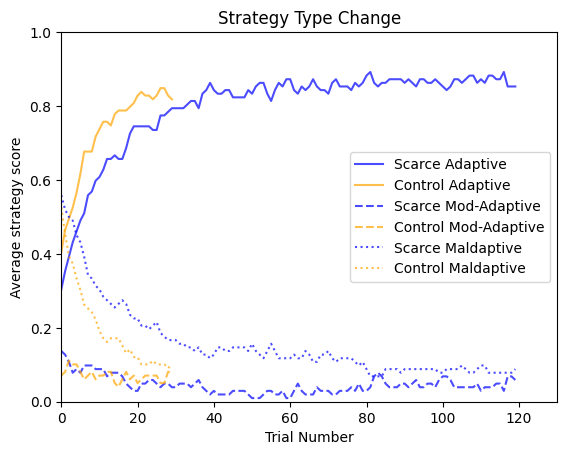

In [127]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

scarce_trial_group = data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers')
control_trial_group = data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers')

# Taking the mean expected score over all trials 
scarce_data_all = np.array(scarce_trial_group.mean()["strategyScores"])
scarce_data_all_sd = np.array(scarce_trial_group.std()["strategyScores"])
control_data = np.array(control_trial_group.mean()["strategyScores"])
control_data_sd = np.array(control_trial_group.std()["strategyScores"])

# Getting the proportions of clusters
scarce_data_adaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==0).sum()) / scarce_trial_group["cluster"].count())
control_data_adaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==0).sum()) / control_trial_group["cluster"].count())
scarce_data_modadaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==1).sum()) / scarce_trial_group["cluster"].count())
control_data_modadaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==1).sum()) / control_trial_group["cluster"].count())
scarce_data_maladaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==2).sum()) / scarce_trial_group["cluster"].count())
control_data_maladaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==2).sum()) / control_trial_group["cluster"].count())
#control_data = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["strategyScores"])
#control_data_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').std()["strategyScores"])

# Taking only the rewarded trials in the scarce condition
rewarded_trials_df = pd.DataFrame(columns=data_to_copy.columns)
for worker in np.unique(data_to_copy.workerId):
    workerRows = data_to_copy.loc[(data_to_copy.scarce == 1) & (data_to_copy.workerId == worker)].reset_index(drop=True)
    rewarded = workerRows.loc[workerRows.rewardsWithheld == False]
    rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))
    rewarded_trials_df = pd.concat([rewarded_trials_df,rewarded], ignore_index=True)

rewarded_trials_df['trialNumbers'] = rewarded_trials_df['trialNumbers'].astype("int64")
rewarded_trials_df['scarce'] = rewarded_trials_df['scarce'].astype("int64")
rewarded_trials_df['numRewardedTrials'] = rewarded_trials_df['numRewardedTrials'].astype("int64")
rewarded_trials_df['numUnrewardedTrials'] = rewarded_trials_df['numUnrewardedTrials'].astype("int64")
rewarded_trials_df['rewardsWithheld'] = rewarded_trials_df['rewardsWithheld'].astype("boolean")
scarce_data_rewarded = np.array(rewarded_trials_df.groupby('trialNumbers').mean()["strategyScores"])
scarce_data_rewarded_sd = np.array(rewarded_trials_df.groupby('trialNumbers').std()["strategyScores"])

plt.figure()
plt.title("Strategy score Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarce")
plt.fill_between(list(range(len(scarce_data_all))), scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.fill_between(list(range(len(control_data))), control_data + control_data_sd, control_data - control_data_sd, alpha=0.1)
plt.axhline(np.max(np.array(strategy_scores_control_list)[:,1], axis=0), color='k', label='Optimal', linestyle="--")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Learning Curves over Rewarded Trials")
plt.plot(list(range(len(scarce_data_rewarded))), scarce_data_rewarded, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Strategy Type Change")
alpha = 0.7
plt.plot(list(range(len(scarce_data_all))), scarce_data_adaptive, label="Scarce Adaptive", color='b',alpha=alpha)
plt.plot(list(range(len(control_data))), control_data_adaptive, label="Control Adaptive",color='orange',alpha=alpha)
plt.plot(list(range(len(scarce_data_all))), scarce_data_modadaptive, label="Scarce Mod-Adaptive", color='b',alpha=alpha, linestyle="--")
plt.plot(list(range(len(control_data))), control_data_modadaptive, label="Control Mod-Adaptive",color='orange',alpha=alpha, linestyle="--")
plt.plot(list(range(len(scarce_data_all))), scarce_data_maladaptive, label="Scarce Maldaptive", color='b',alpha=alpha, linestyle=":")
plt.plot(list(range(len(control_data))), control_data_maladaptive, label="Control Maldaptive",color='orange',alpha=alpha, linestyle=":")
plt.legend()
plt.ylim([0,1])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()


In [294]:
# Setting up logistic regression

data_to_copy = analysis_data.copy()
data_to_copy["cluster"] = data_to_copy["cluster"].astype("int64")

formula = "cluster ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

model_1 = statsmodels.discrete.discrete_model.MNLogit.from_formula(formula, data_to_copy)
model_1_fit = model.fit()

endog = analysis_data["cluster"].astype("int64").map(lambda c: ["cat","dog","bear"][c])
exog = analysis_data[["trialNumbers", "scarce"]]
exog["trialNumbers:scarce"] = exog["trialNumbers"] * exog["scarce"]
exog["const"] = [1] * len(exog)

model_2 = statsmodels.discrete.discrete_model.MNLogit(endog, exog)
model_2_fit = model.fit()

print(model_1_fit.summary())
print(model_2_fit.summary())

Optimization terminated successfully.
         Current function value: 0.608218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608218
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                15210
Model:                        MNLogit   Df Residuals:                    15202
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Oct 2022   Pseudo R-squ.:                 0.04896
Time:                        11:32:54   Log-Likelihood:                -9251.0
converged:                       True   LL-Null:                       -9727.3
Covariance Type:            nonrobust   LLR p-value:                1.652e-202
                  cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/3125500743.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["trialNumbers:scarce"] = exog["trialNumbers"] * exog["scarce"]
/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/3125500743.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["const"] = [1] * len(exog)


                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                15210
Model:                        MNLogit   Df Residuals:                    15202
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Oct 2022   Pseudo R-squ.:                 0.04896
Time:                        11:32:54   Log-Likelihood:                -9251.0
converged:                       True   LL-Null:                       -9727.3
Covariance Type:            nonrobust   LLR p-value:                1.652e-202
                  cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.8616      0.145    -12.815      0.000      -2.146      -1.577
C(scarce)[T.1]                 -0.4777      0.167     -2.858      0.004      -0.

In [295]:
sum(model_2.endog == model_1.endog) / len(model_2.endog)

0.0

# 1.6 - Stable Strategy Comparisons

In [41]:
filtered_data['strategy'] = filtered_data['strategy'].astype('int64')

In [58]:
measure = 'mode' #median, mode

if measure == 'median':
    scarce_end_strat = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers > 60)].groupby('workerId').median()['strategy'].astype('int64')
    control_end_strat = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers > 15)].groupby('workerId').median()['strategy'].astype('int64')
elif measure == 'mode':
    scarce_end_strat = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers > 60)].groupby('workerId')['strategy'].agg(pd.Series.mode)#.astype('int64')
    control_end_strat = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers > 15)].groupby('workerId')['strategy'].agg(pd.Series.mode)#.astype('int64')

workerId
59da7e94416c900001ea5b52          26
5b01647dc66dc6000197d6ea          21
5b222aff59f9620001c109cb          76
5bb37f5aff6a9b0001d148b6          17
5be0a4f8c83f480001a9d302          21
                              ...   
62b1ff970dfb7055f35d6937    [40, 63]
6304ce399cd59f756062e51f          21
6310e17611985c88ead974e1          21
631a24dfca851aac1863e4a4          21
6320b0f0782ad75ec20759ea          42
Name: strategy, Length: 102, dtype: object

In [62]:
table = np.zeros((89,2))

for strat in scarce_end_strat:
    print(type(strat))
    if type(strat) != int:
        strat = strat[0]
    table[strat][1] += 1
    
for strat in control_end_strat:
    if type(strat) != int:
        strat = strat[0]
    table[strat][0] += 1
    
table

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'nu

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 2.,  1.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  2.],
       [ 0.,  1.],
       [ 0.,  3.],
       [ 0.,  0.],
       [ 0.,  0.],
       [48., 37.],
       [ 1.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 5.,  8.],
       [ 4.,  3.],
       [ 2.,  1.],
       [ 0.,  0.],
       [ 7.,  7.],
       [ 8.,  5.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 3.,  2.],
       [ 0.,  0.],
       [ 1.,  3.],
       [ 1.,  3.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  3.],
       [ 1.,  0.],
       [ 0.,

# Appendix

### Visualization of Distributions of Exclusion Criteria Statistics

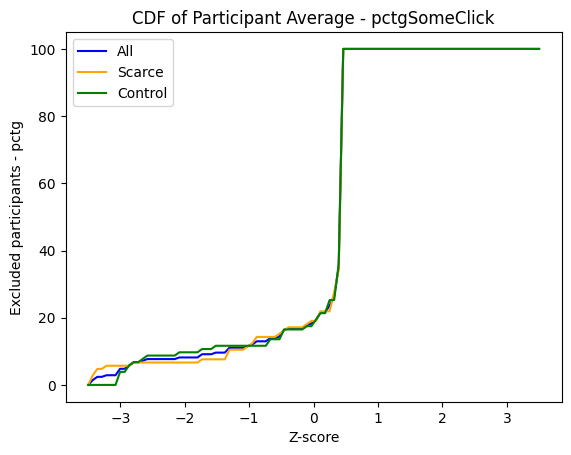

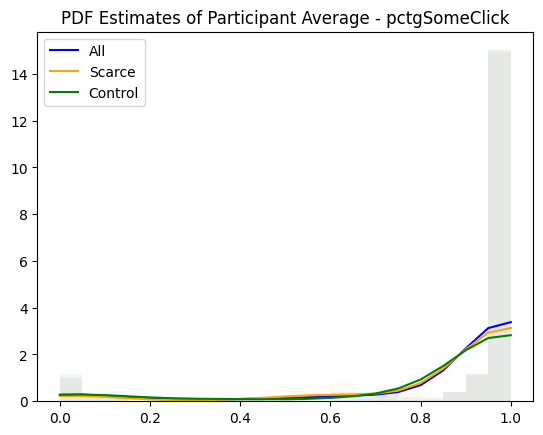

In [14]:
# Sensitivity analysis of zscore threshold for exclusion


exclusion_criteria = "pctgSomeClick" # column of all_part_averages
z_threshs = np.linspace(-3.5, 3.5, 100);

excluded = {
    "scarce": {
        "abs": [],
        "pctg": []
    },
    "control": {
        "abs": [],
        "pctg": []
    },
    "all": {
        "abs": [],
        "pctg": []
    }
    
}
for thresh in z_threshs:
    excluded_parts_control = control_part_averages[scipy.stats.zscore(control_part_averages[exclusion_criteria]) < thresh]
    included_parts_control = control_part_averages[scipy.stats.zscore(control_part_averages[exclusion_criteria]) >= thresh]

    excluded_parts_scarce = scarce_part_averages[scipy.stats.zscore(scarce_part_averages[exclusion_criteria]) < thresh]
    included_parts_scarce = scarce_part_averages[scipy.stats.zscore(scarce_part_averages[exclusion_criteria]) >= thresh]

    num_excluded_parts = len(excluded_parts_scarce) + len(excluded_parts_control)

    excluded["all"]["abs"].append(num_excluded_parts)
    excluded["all"]["pctg"].append(100 * num_excluded_parts / len(all_trials_df.groupby("workerId")))
    
    excluded["control"]["abs"].append(len(excluded_parts_control))
    excluded["control"]["pctg"].append(100 * len(excluded_parts_control) / len(control_part_averages))
                                     
    excluded["scarce"]["abs"].append(len(excluded_parts_scarce))
    excluded["scarce"]["pctg"].append(100 * len(excluded_parts_scarce) / len(scarce_part_averages))

which_plot = "pctg" #abs, pctg
plt.title("CDF of Participant Average - {}".format(exclusion_criteria))
plt.plot(z_threshs, excluded["all"][which_plot], label = "All",color='b')
plt.plot(z_threshs, excluded["scarce"][which_plot], label = "Scarce", color='orange')
plt.plot(z_threshs, excluded["control"][which_plot], label = "Control", color='g')
plt.xlabel("Z-score")
plt.ylabel("Excluded participants - {}".format(which_plot))
plt.legend()

plt.figure()
binwidth = 0.05
data = all_part_averages[exclusion_criteria]
plt.title("PDF Estimates of Participant Average - {}".format(exclusion_criteria))
density_all = scipy.stats.gaussian_kde(data)
n, x, _ = plt.hist(data, density=True, color='b', alpha=0.05, bins=np.arange(min(data), max(data) + binwidth, binwidth))
plt.plot(x, density_all(x), label="All", color='b')

data = scarce_part_averages[exclusion_criteria]                   
density_s = scipy.stats.gaussian_kde(data)
n, x, _ = plt.hist(data, density=True, color='orange', alpha=0.05, bins=np.arange(min(data), max(data) + binwidth, binwidth))
plt.plot(x, density_s(x), label="Scarce", color='orange')

data = control_part_averages[exclusion_criteria]      
density_c = scipy.stats.gaussian_kde(data)
n, x, _ = plt.hist(data, density=True, color='g', alpha=0.05, bins=np.arange(min(data), max(data) + binwidth, binwidth))
plt.plot(x, density_c(x), label="Control", color='g')

plt.legend()
                                                                       
plt.show()

In [15]:
# Select the exclusion criteria

selected_exclusion_col = "pctgSomeClick"

In [54]:
# Cross-checking adaptiveness of strategies

adaptive_strats = [65, 64, 24, 21, 63, 43,
    17, 16, 57, 59, 88, 54,
    4, 31, 26, 82, 37, 48,
    50, 85, 76, 18, 84, 45,
    11, 6, 7, 29, 80, 36, 67,
    12, 87, 60, 5, 10, 49,
    42, 72, 51, 2, 71, 13,
    40, 14, 15, 78, 56]

m_adaptive_strats = [33, 44, 27, 79, 69,
34, 61, 73, 32]

maladaptive_strats = [22, 53, 39, 28, 30,
23, 66, 70, 74]

for idx, (strat_list, label) in enumerate(zip([adaptive_strats, m_adaptive_strats, maladaptive_strats], ["Adaptive", "Moderate", "Maladaptive"])):
    print("\n" + label)
    for strat in strat_list:
        print(strat, scarce_cluster_dict[strat-1] == idx, control_cluster_dict[strat-1] == idx)
    


Adaptive
65 True True
64 True True
24 True True
21 True True
63 True True
43 True True
17 True True
16 True True
57 True True
59 True True
88 True True
54 True True
4 True True
31 True True
26 True True
82 True True
37 True True
48 True True
50 True True
85 True True
76 True True
18 True True
84 True True
45 True True
11 True True
6 True True
7 True True
29 True True
80 True True
36 True True
67 True True
12 True True
87 True True
60 True True
5 True True
10 True True
49 True True
42 True True
72 True True
51 True True
2 True True
71 True True
13 True True
40 True True
14 True True
15 True True
78 True True
56 True True

Moderate
33 True True
44 True True
27 True True
79 True True
69 True True
34 True True
61 True True
73 True True
32 True True

Maladaptive
22 True True
53 True True
39 True True
28 True True
30 True True
23 True True
66 True True
70 True True
74 True True
